In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import optuna

In [21]:
# Modelling Libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from optuna.samplers import TPESampler

# Evaluation & CV Libraries
from sklearn.metrics import precision_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, StratifiedKFold, cross_val_score, KFold

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

In [3]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

In [5]:
# Each entry of the flights.csv file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

# YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
# AIRLINE: An identification number assigned by US DOT to identify a unique airline
# ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports
# SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing
# DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place
# DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times



### The main goal of this project is to predict arrival delay

In [6]:
# I remove Nans from columns where flights were cancelled (or diverted)
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)
# I remove columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# I remove columns with insufficient data
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [7]:
# In the initial dataframe, dates are coded according to 4 variables: YEAR, MONTH, DAY, and DAY_OF_WEEK. 
# I change it into datetime format:
import datetime
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
# I'll need name of the week and month name
df['DAY_NAME'] = df['DATE'].dt.day_name()
df['MONTH_NAME'] = df['DATE'].dt.month_name()
# I remove those 4 unnecessary columns
df.drop(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK'], axis=1, inplace=True)

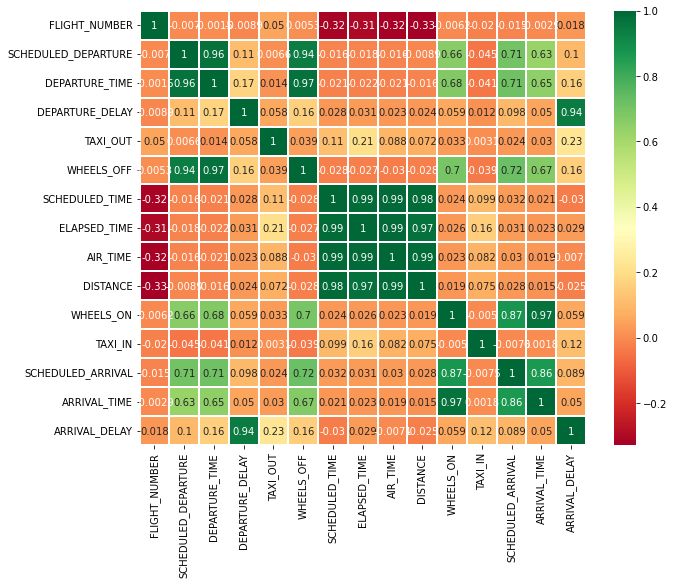

In [8]:
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

### Departure_delay column is the most correlated data with arrival_delay, but I want to predict arrival delays before the flight.

In [9]:
# My goal is to predict if the arrival will be delayed or not, that's why I removed columns that have nothing to do with the goal:
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'DEPARTURE_DELAY', 'DEPARTURE_TIME',
             'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME'], axis=1, inplace=True)

In [10]:
df.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME
4228823,EV,TYS,IAH,645,138.0,771,803,-5.0,2015-09-21,Monday,September
4374486,DL,MSY,ATL,1015,88.0,425,1243,-15.0,2015-09-30,Wednesday,September
4812847,WN,11259,14107,615,155.0,879,650,-8.0,2015-10-28,Wednesday,October
1380679,WN,DCA,MCI,1535,175.0,949,1730,-31.0,2015-03-30,Monday,March
1651193,EV,ACT,DFW,1010,47.0,89,1057,4.0,2015-04-16,Thursday,April
5689732,WN,LAX,LAS,1200,65.0,236,1305,-1.0,2015-12-23,Wednesday,December
2157462,MQ,DFW,HOU,1756,68.0,247,1904,51.0,2015-05-17,Sunday,May
3116575,EV,AVP,ORD,1730,125.0,632,1835,58.0,2015-07-14,Tuesday,July
1680457,EV,VPS,IAH,615,115.0,528,810,-5.0,2015-04-18,Saturday,April
5334594,NK,DFW,ORD,1640,139.0,802,1859,9.0,2015-11-30,Monday,November


In [11]:
# SCHEDULED_DEPARTURE and _ARRIVAL - this columns shows hours and minutes from departures and arrivals
# I'm changing it into full hours
df['SCHEDULED_DEPARTURE_H'] = df['SCHEDULED_DEPARTURE'] // 100
df['SCHEDULED_ARRIVAL_H'] = df['SCHEDULED_ARRIVAL'] // 100
# Remove column SCHEDULED_DEPARTURE:
df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1, inplace=True)

# In the data there was one position with hour = 24 (should be 00)
df['SCHEDULED_ARRIVAL_H'].replace(24, 0, inplace=True)

## An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [12]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [13]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [14]:
# Chcking the Nan values
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [15]:
# taking real world data for missing values:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [16]:
# In airports.csv we have airports only from one country - USA
airports['COUNTRY'].value_counts()

USA    322
Name: COUNTRY, dtype: int64

In [17]:
# In airports.csv we have airports from 54 states of USA
airports['STATE'].unique().shape

(54,)

In [18]:
# In the dataframe there are also airports that are not in the airport.csv file
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [12]:
# I remove the data where airports are shown in 5-digit code and create new dataframe - df_air
df_air= df[df['ORIGIN_AIRPORT'] > 'AAA']
df_air.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AIRLINE                5231130 non-null  object        
 1   ORIGIN_AIRPORT         5231130 non-null  object        
 2   DESTINATION_AIRPORT    5231130 non-null  object        
 3   SCHEDULED_TIME         5231130 non-null  float64       
 4   DISTANCE               5231130 non-null  int64         
 5   ARRIVAL_DELAY          5231130 non-null  float64       
 6   DATE                   5231130 non-null  datetime64[ns]
 7   DAY_NAME               5231130 non-null  object        
 8   MONTH_NAME             5231130 non-null  object        
 9   SCHEDULED_DEPARTURE_H  5231130 non-null  int64         
 10  SCHEDULED_ARRIVAL_H    5231130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 478.9+ MB


## An additional file of this dataset, the airlines.csv file, gives a more exhaustive description of the airlines:

In [20]:
airlines_names=pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [21]:
# I create a dictionary with IATA_CODE and AIRLINE name
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

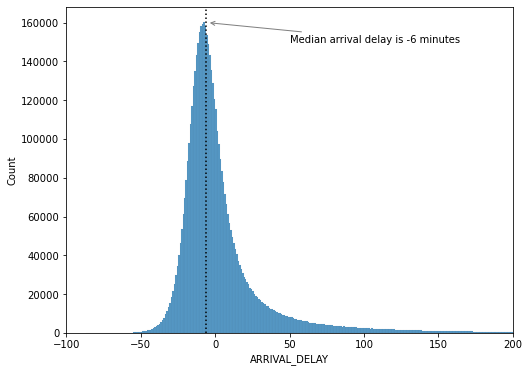

In [22]:
plt.figure(figsize=(8,6))
ax = sns.histplot(x='ARRIVAL_DELAY', data=df_air, binwidth=1)
ax.axvline(x=-6, linestyle='dotted', color='black')
ax.annotate('Median arrival delay is -6 minutes', xy=[-5,160000], 
           xytext=[50, 150000],
           arrowprops={'arrowstyle': '->', 'color':'gray'})
plt.xlim(-100, 200)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_4428\7107336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air["delayed"] = pd.cut( x=df_air["ARRIVAL_DELAY"], bins=[-100, 0, np.inf], labels=[0, 1])


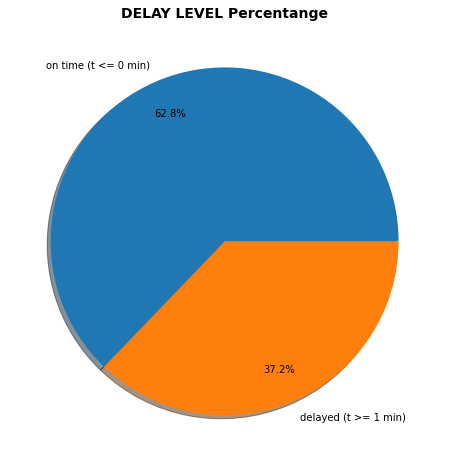

In [13]:
# Function that define how delays are grouped
df_air["delayed"] = pd.cut( x=df_air["ARRIVAL_DELAY"], bins=[-100, 0, np.inf], labels=[0, 1])

# 
delay_level = dict(df_air.groupby('delayed')['delayed'].count())
labels = ['on time (t <= 0 min)', 'delayed (t >= 1 min)']
values = delay_level.values()
plt.figure(figsize=(8,8))
plt.pie(data=df_air, x=values, labels= labels, autopct = '%1.1f%%', pctdistance=0.8, shadow=True)
plt.title('DELAY LEVEL Percentange', fontsize=14, weight = 'bold')
plt.show()

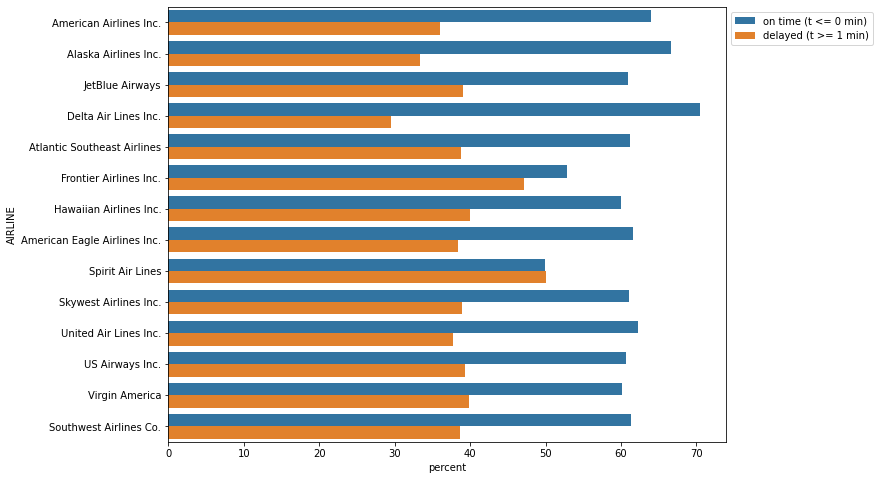

In [24]:
df1 = df_air.groupby('AIRLINE')['delayed'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1['AIRLINE'] = df1['AIRLINE'].replace(abbr_companies)

plt.figure(figsize=(10,8))
sns.barplot(y='AIRLINE', x='percent', hue='level_1', data=df1)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

## Time charts

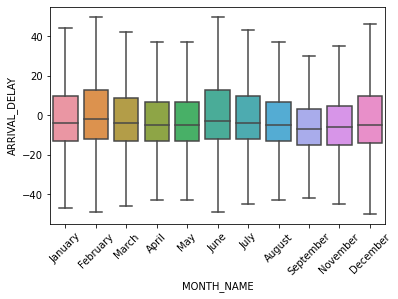

In [25]:
# Boxplot:  Month name vs arrival_delay
sns.boxplot(x='MONTH_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.xticks(rotation=45)
plt.show()

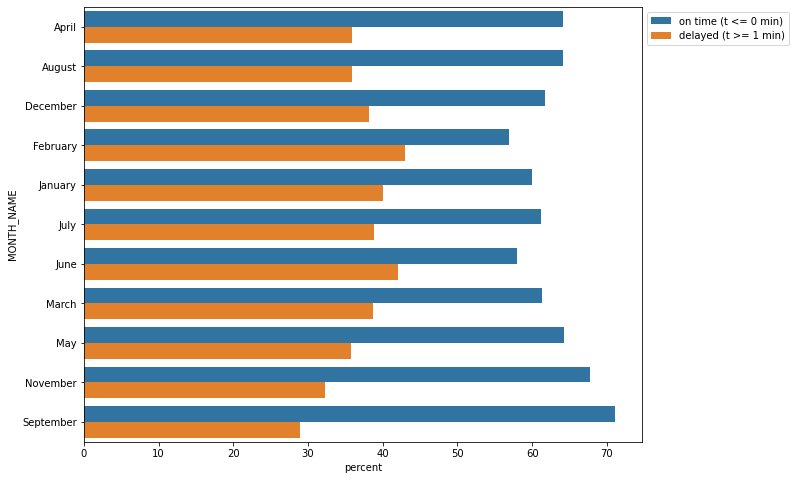

In [26]:
# Bar chart: Flight count delays vs month name

x,y =  'MONTH_NAME', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(10,8))
sns.barplot(y='MONTH_NAME', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

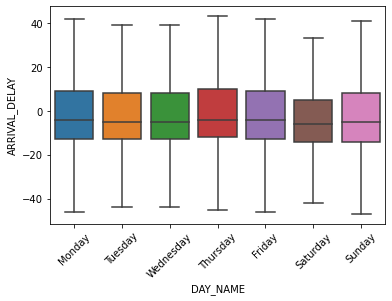

In [27]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='DAY_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False, order=weekdays)
plt.xticks(rotation=45)
plt.show()

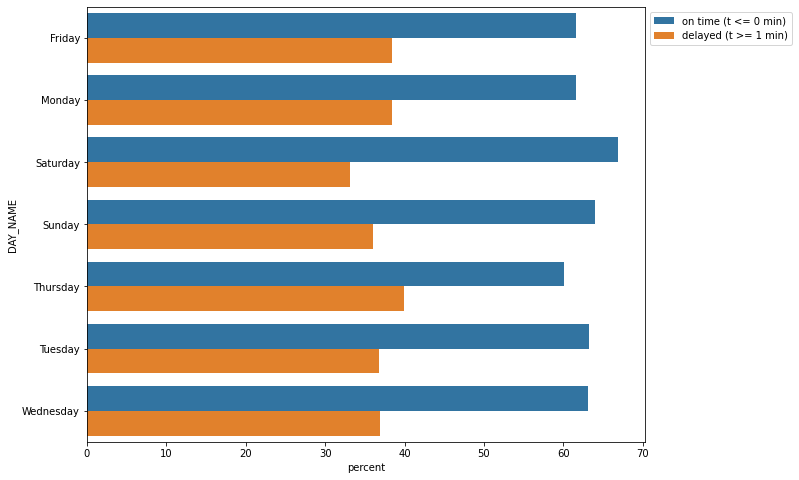

In [28]:
# Bar chart: Flight count delays vs week name

x,y =  'DAY_NAME', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(10,8))
sns.barplot(y='DAY_NAME', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_4428\527070438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['DAY_TYPE'] = df['DAY_NAME'].replace(mappings)


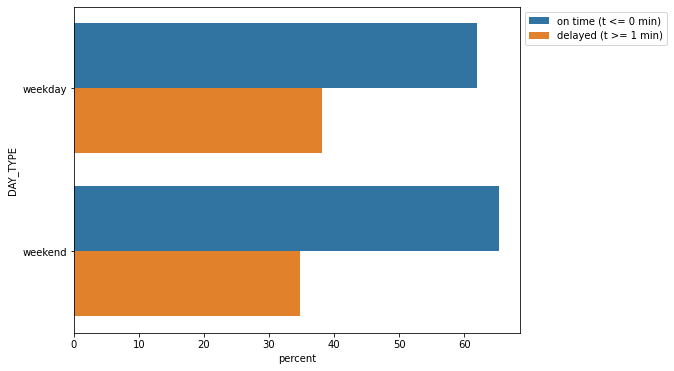

In [14]:
mappings = { 'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday':'weekday', 'Thursday':'weekday',
           'Friday':'weekday', 'Saturday':'weekend', 'Sunday':'weekend'}

df_air['DAY_TYPE'] = df['DAY_NAME'].replace(mappings)

x,y =  'DAY_TYPE', 'delayed'

df_mn = df_air.groupby(x)[y].value_counts(normalize=True)
df_mn = df_mn.mul(100)
df_mn = df_mn.rename('percent').reset_index()

plt.figure(figsize=(8,6))
sns.barplot(y='DAY_TYPE', x='percent', hue='level_1', data=df_mn)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('delayed (t >= 1 min)') 
plt.show()


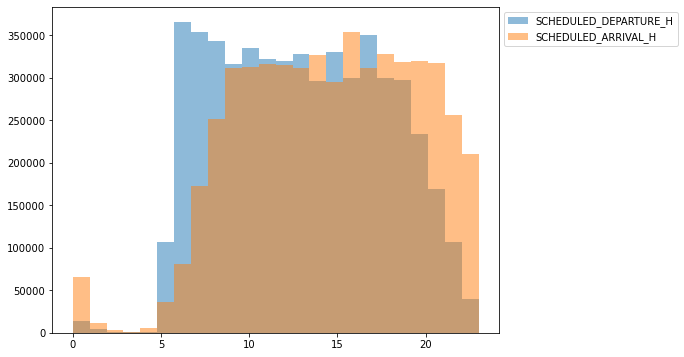

In [30]:
fig, ax=plt.subplots(figsize=(8,6))
ax.hist(df_air['SCHEDULED_DEPARTURE_H'], label='SCHEDULED_DEPARTURE_H', alpha=0.5, bins=24)
ax.hist(df_air['SCHEDULED_ARRIVAL_H'], label='SCHEDULED_ARRIVAL_H', alpha=0.5, bins=24)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

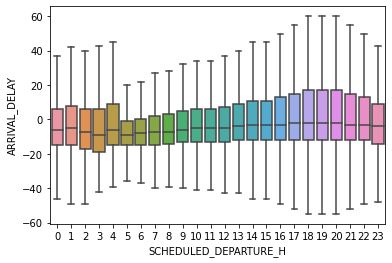

In [31]:
sns.boxplot(x='SCHEDULED_DEPARTURE_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

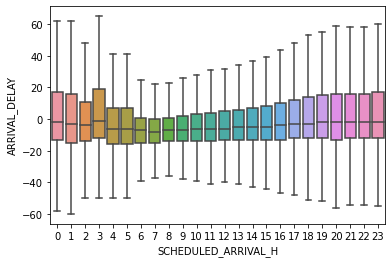

In [32]:
sns.boxplot(x='SCHEDULED_ARRIVAL_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

### Delay map

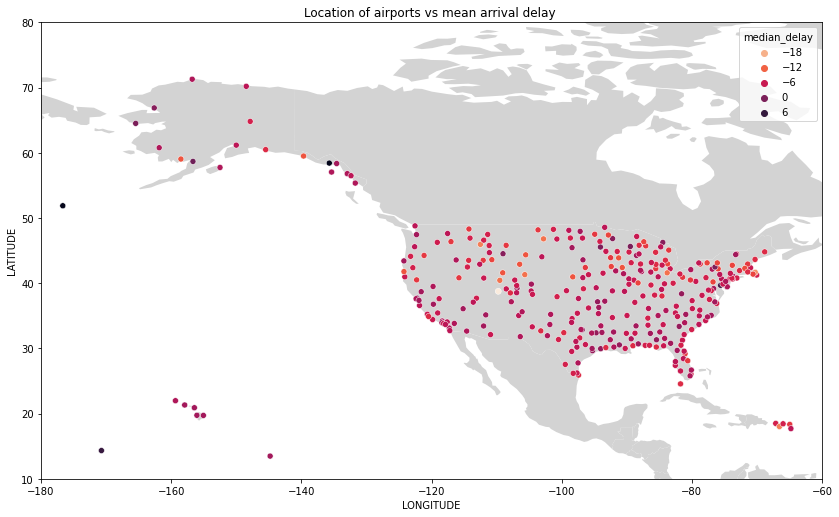

In [36]:
# Create new table with information about arrival delay and airports coordinates
df3 = df_air.loc[:, ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']]
df4 = df3.merge(airports, how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

# Group by origin airport to count mean arrival delay
delay_map_dep = df4.groupby('ORIGIN_AIRPORT').agg(
                    median_delay=('ARRIVAL_DELAY', 'median'), 
                    LATITUDE=('LATITUDE', 'mean'), LONGITUDE=('LONGITUDE', 'mean'))

# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(14, 9))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Mean_delay data with a color map
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=delay_map_dep, hue='median_delay', palette='rocket_r')
plt.title('Location of airports vs mean arrival delay ', fontsize=12)
plt.xlim([-180, -60])
plt.ylim([10, 80])
plt.show()

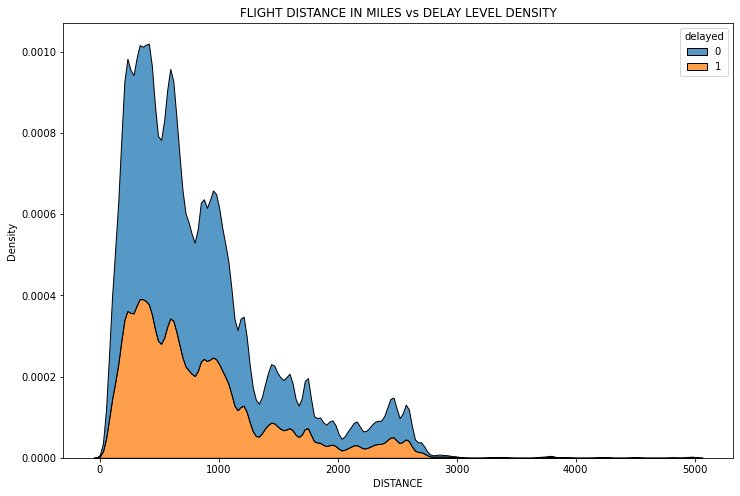

In [37]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='DISTANCE', hue='delayed', data=df_air, multiple="stack")
plt.title('FLIGHT DISTANCE IN MILES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

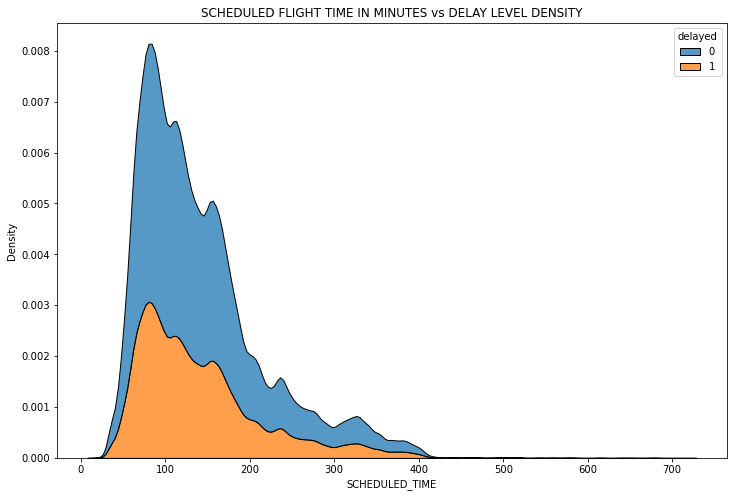

In [38]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='SCHEDULED_TIME', hue='delayed', data=df_air, multiple="stack")
plt.title('SCHEDULED FLIGHT TIME IN MINUTES vs DELAY LEVEL DENSITY', fontsize=12)
plt.show()

## Model sam styczeń

In [15]:
df_1 = df_air[df_air['MONTH_NAME'] == 'January']

df_1.drop(['ARRIVAL_DELAY', 'DATE', 'MONTH_NAME'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_4428\328097134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(['ARRIVAL_DELAY', 'DATE', 'MONTH_NAME'], axis=1, inplace=True)


In [16]:
# one hot encoding
df_ohe1 = pd.get_dummies(data=df_1, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                                             'DAY_NAME', 'DAY_TYPE'])

In [17]:
y=df_ohe1.pop('delayed')
X=df_ohe1

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
models =[("LR", LogisticRegression(random_state=1)), ('RF',RandomForestClassifier(random_state=1)),
         ("GNB", GaussianNB()), ('LGBM', LGBMClassifier(random_state=1)),
         ("XGB", XGBClassifier(random_state=1)), ("DTC", DecisionTreeClassifier()),
         ('ADA',AdaBoostClassifier(random_state=1)), ("GB",GradientBoostingClassifier(random_state=1)),
         ("RDG", RidgeClassifier()), ('CTB', CatBoostClassifier(random_state=1))]

results_roc_train = []
results_roc_test = []
names = []
finalResults_roc = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results_train = model.predict(X_train)
    score_train = roc_auc_score(y_train, model_results_train)
    model_results_test = model.predict(X_test)
    score_test = roc_auc_score(y_test, model_results_test)
    results_roc_train.append(score_train)
    results_roc_test.append(score_test)
    names.append(name)
    finalResults_roc.append((name,score_train,score_test))  # 19 min

In [60]:
# print the roc_auc_scores on train and test set
df_results_auc = pd.DataFrame(data=finalResults_auc, 
                          columns=['Model', 'ROC AUC sore on train set', 'ROC AUC sore on test set'])
print(df_results_auc)

  Model  ROC AUC sore on train set  ROC AUC sore on test set
0    LR                   0.569432                  0.569174
1   GNB                   0.554987                  0.550742
2   XGB                   0.597876                  0.586724
3   DTC                   0.777939                  0.557132
4   ADA                   0.551387                  0.553486
5    GB                   0.553829                  0.556368
6   RDG                   0.568147                  0.568111
7   SGD                   0.533530                  0.532807


In [22]:
models =[("LR", LogisticRegression(random_state=1)), ('RF',RandomForestClassifier(random_state=1)),
         ("GNB", GaussianNB()), ('LGBM', LGBMClassifier(random_state=1)),
         ("XGB", XGBClassifier(random_state=1)), ("DTC", DecisionTreeClassifier()),
         ('ADA',AdaBoostClassifier(random_state=1)), ("GB",GradientBoostingClassifier(random_state=1)),
         ("RDG", RidgeClassifier()), ('CTB', CatBoostClassifier(random_state=1))]

results_acc_train = []
results_acc_test = []
names = []
finalResults_acc = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results_train = model.predict(X_train)
    score_train = accuracy_score(y_train, model_results_train)
    model_results_test = model.predict(X_test)
    score_test = accuracy_score(y_test, model_results_test)
    results_acc_train.append(score_train)
    results_acc_test.append(score_test)
    names.append(name)
    finalResults_acc.append((name,score_train,score_test))  # ok. 30 min

Learning rate set to 0.128039
0:	learn: 0.6845630	total: 206ms	remaining: 3m 25s
1:	learn: 0.6779930	total: 267ms	remaining: 2m 13s
2:	learn: 0.6729348	total: 325ms	remaining: 1m 48s
3:	learn: 0.6690237	total: 377ms	remaining: 1m 33s
4:	learn: 0.6659612	total: 423ms	remaining: 1m 24s
5:	learn: 0.6635179	total: 457ms	remaining: 1m 15s
6:	learn: 0.6616869	total: 492ms	remaining: 1m 9s
7:	learn: 0.6601692	total: 526ms	remaining: 1m 5s
8:	learn: 0.6589609	total: 557ms	remaining: 1m 1s
9:	learn: 0.6579605	total: 584ms	remaining: 57.8s
10:	learn: 0.6570752	total: 612ms	remaining: 55s
11:	learn: 0.6564071	total: 647ms	remaining: 53.3s
12:	learn: 0.6557315	total: 676ms	remaining: 51.3s
13:	learn: 0.6551534	total: 705ms	remaining: 49.7s
14:	learn: 0.6545776	total: 735ms	remaining: 48.2s
15:	learn: 0.6541068	total: 762ms	remaining: 46.9s
16:	learn: 0.6537798	total: 792ms	remaining: 45.8s
17:	learn: 0.6534194	total: 820ms	remaining: 44.8s
18:	learn: 0.6531251	total: 850ms	remaining: 43.9s
19:	lea

161:	learn: 0.6374339	total: 6.64s	remaining: 34.4s
162:	learn: 0.6373790	total: 6.7s	remaining: 34.4s
163:	learn: 0.6373302	total: 6.75s	remaining: 34.4s
164:	learn: 0.6372946	total: 6.8s	remaining: 34.4s
165:	learn: 0.6372444	total: 6.86s	remaining: 34.4s
166:	learn: 0.6371915	total: 6.91s	remaining: 34.5s
167:	learn: 0.6371310	total: 6.96s	remaining: 34.5s
168:	learn: 0.6370796	total: 7.01s	remaining: 34.5s
169:	learn: 0.6370341	total: 7.06s	remaining: 34.5s
170:	learn: 0.6369916	total: 7.12s	remaining: 34.5s
171:	learn: 0.6369368	total: 7.17s	remaining: 34.5s
172:	learn: 0.6368963	total: 7.22s	remaining: 34.5s
173:	learn: 0.6368584	total: 7.27s	remaining: 34.5s
174:	learn: 0.6368024	total: 7.32s	remaining: 34.5s
175:	learn: 0.6367433	total: 7.39s	remaining: 34.6s
176:	learn: 0.6367147	total: 7.45s	remaining: 34.6s
177:	learn: 0.6366475	total: 7.49s	remaining: 34.6s
178:	learn: 0.6366103	total: 7.54s	remaining: 34.6s
179:	learn: 0.6365517	total: 7.59s	remaining: 34.6s
180:	learn: 0.

323:	learn: 0.6304574	total: 15.6s	remaining: 32.5s
324:	learn: 0.6304157	total: 15.6s	remaining: 32.5s
325:	learn: 0.6303806	total: 15.7s	remaining: 32.5s
326:	learn: 0.6303512	total: 15.8s	remaining: 32.4s
327:	learn: 0.6303081	total: 15.8s	remaining: 32.4s
328:	learn: 0.6302772	total: 15.9s	remaining: 32.4s
329:	learn: 0.6302486	total: 15.9s	remaining: 32.3s
330:	learn: 0.6302050	total: 16s	remaining: 32.3s
331:	learn: 0.6301800	total: 16s	remaining: 32.3s
332:	learn: 0.6301447	total: 16.1s	remaining: 32.2s
333:	learn: 0.6301111	total: 16.2s	remaining: 32.2s
334:	learn: 0.6300785	total: 16.2s	remaining: 32.2s
335:	learn: 0.6300441	total: 16.3s	remaining: 32.2s
336:	learn: 0.6299938	total: 16.3s	remaining: 32.1s
337:	learn: 0.6299659	total: 16.4s	remaining: 32.1s
338:	learn: 0.6299425	total: 16.4s	remaining: 32.1s
339:	learn: 0.6299278	total: 16.5s	remaining: 32s
340:	learn: 0.6298916	total: 16.6s	remaining: 32s
341:	learn: 0.6298555	total: 16.6s	remaining: 32s
342:	learn: 0.6298207	

485:	learn: 0.6256138	total: 24.4s	remaining: 25.8s
486:	learn: 0.6255954	total: 24.4s	remaining: 25.7s
487:	learn: 0.6255634	total: 24.5s	remaining: 25.7s
488:	learn: 0.6255301	total: 24.5s	remaining: 25.6s
489:	learn: 0.6255117	total: 24.6s	remaining: 25.6s
490:	learn: 0.6254891	total: 24.6s	remaining: 25.5s
491:	learn: 0.6254744	total: 24.7s	remaining: 25.5s
492:	learn: 0.6254603	total: 24.7s	remaining: 25.4s
493:	learn: 0.6254469	total: 24.8s	remaining: 25.4s
494:	learn: 0.6254134	total: 24.8s	remaining: 25.3s
495:	learn: 0.6253903	total: 24.9s	remaining: 25.3s
496:	learn: 0.6253579	total: 24.9s	remaining: 25.2s
497:	learn: 0.6253261	total: 25s	remaining: 25.2s
498:	learn: 0.6252987	total: 25s	remaining: 25.1s
499:	learn: 0.6252742	total: 25.1s	remaining: 25.1s
500:	learn: 0.6252625	total: 25.1s	remaining: 25s
501:	learn: 0.6252390	total: 25.2s	remaining: 25s
502:	learn: 0.6252242	total: 25.2s	remaining: 24.9s
503:	learn: 0.6251991	total: 25.3s	remaining: 24.9s
504:	learn: 0.625178

645:	learn: 0.6218621	total: 32.9s	remaining: 18s
646:	learn: 0.6218390	total: 33s	remaining: 18s
647:	learn: 0.6218126	total: 33s	remaining: 17.9s
648:	learn: 0.6217920	total: 33.1s	remaining: 17.9s
649:	learn: 0.6217662	total: 33.1s	remaining: 17.8s
650:	learn: 0.6217497	total: 33.2s	remaining: 17.8s
651:	learn: 0.6217146	total: 33.2s	remaining: 17.7s
652:	learn: 0.6216910	total: 33.3s	remaining: 17.7s
653:	learn: 0.6216651	total: 33.3s	remaining: 17.6s
654:	learn: 0.6216350	total: 33.4s	remaining: 17.6s
655:	learn: 0.6216069	total: 33.4s	remaining: 17.5s
656:	learn: 0.6215806	total: 33.5s	remaining: 17.5s
657:	learn: 0.6215581	total: 33.5s	remaining: 17.4s
658:	learn: 0.6215326	total: 33.6s	remaining: 17.4s
659:	learn: 0.6215200	total: 33.6s	remaining: 17.3s
660:	learn: 0.6214981	total: 33.7s	remaining: 17.3s
661:	learn: 0.6214763	total: 33.8s	remaining: 17.2s
662:	learn: 0.6214482	total: 33.8s	remaining: 17.2s
663:	learn: 0.6214159	total: 33.9s	remaining: 17.1s
664:	learn: 0.621397

808:	learn: 0.6184247	total: 41.5s	remaining: 9.8s
809:	learn: 0.6184104	total: 41.6s	remaining: 9.75s
810:	learn: 0.6183904	total: 41.6s	remaining: 9.7s
811:	learn: 0.6183789	total: 41.7s	remaining: 9.65s
812:	learn: 0.6183602	total: 41.7s	remaining: 9.6s
813:	learn: 0.6183440	total: 41.8s	remaining: 9.55s
814:	learn: 0.6183383	total: 41.8s	remaining: 9.5s
815:	learn: 0.6183273	total: 41.9s	remaining: 9.44s
816:	learn: 0.6183138	total: 42s	remaining: 9.4s
817:	learn: 0.6182863	total: 42s	remaining: 9.35s
818:	learn: 0.6182735	total: 42.1s	remaining: 9.29s
819:	learn: 0.6182591	total: 42.1s	remaining: 9.24s
820:	learn: 0.6182448	total: 42.2s	remaining: 9.2s
821:	learn: 0.6182286	total: 42.2s	remaining: 9.14s
822:	learn: 0.6182200	total: 42.3s	remaining: 9.1s
823:	learn: 0.6181942	total: 42.3s	remaining: 9.04s
824:	learn: 0.6181762	total: 42.4s	remaining: 8.99s
825:	learn: 0.6181581	total: 42.4s	remaining: 8.94s
826:	learn: 0.6181484	total: 42.5s	remaining: 8.89s
827:	learn: 0.6181227	t

967:	learn: 0.6155230	total: 50.6s	remaining: 1.67s
968:	learn: 0.6154991	total: 50.6s	remaining: 1.62s
969:	learn: 0.6154785	total: 50.7s	remaining: 1.57s
970:	learn: 0.6154592	total: 50.8s	remaining: 1.52s
971:	learn: 0.6154404	total: 50.8s	remaining: 1.46s
972:	learn: 0.6154261	total: 50.9s	remaining: 1.41s
973:	learn: 0.6154081	total: 50.9s	remaining: 1.36s
974:	learn: 0.6153901	total: 51s	remaining: 1.31s
975:	learn: 0.6153793	total: 51s	remaining: 1.25s
976:	learn: 0.6153678	total: 51.1s	remaining: 1.2s
977:	learn: 0.6153550	total: 51.1s	remaining: 1.15s
978:	learn: 0.6153421	total: 51.2s	remaining: 1.1s
979:	learn: 0.6153339	total: 51.2s	remaining: 1.04s
980:	learn: 0.6153151	total: 51.3s	remaining: 993ms
981:	learn: 0.6153068	total: 51.3s	remaining: 941ms
982:	learn: 0.6152911	total: 51.4s	remaining: 889ms
983:	learn: 0.6152842	total: 51.4s	remaining: 836ms
984:	learn: 0.6152701	total: 51.5s	remaining: 784ms
985:	learn: 0.6152531	total: 51.5s	remaining: 732ms
986:	learn: 0.6152

In [24]:
# print the roc_auc_scores on train and test set
df_results_acc = pd.DataFrame(data=finalResults_acc, 
                          columns=['Model', 'Accuracy sore on train set', 'Accuracy sore on test set'])
print(df_results_acc)

  Model  ROC AUC sore on train set  ROC AUC sore on test set
0    LR                   0.625653                  0.625155
1    RF                   0.807970                  0.591469
2   GNB                   0.528509                  0.524228
3  LGBM                   0.640322                  0.638458
4   XGB                   0.651437                  0.640614
5   DTC                   0.807981                  0.598602
6   ADA                   0.614641                  0.616030
7    GB                   0.623112                  0.624936
8   RDG                   0.625732                  0.625516
9   CTB                   0.661210                  0.647725


### Added class_weight to LR and LGBM

In [33]:
class_weight = {0:37.2, 1:62.8}
lr = LogisticRegression(random_state=1, class_weight=class_weight)
lr.fit(X_train, y_train)
lr_results_train = lr.predict(X_train)
lr_results_test = lr.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, lr_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, lr_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, lr_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, lr_results_test)))

Accuracy score in train set: 0.577
Accuracy score in test set: 0.579
ROC AUC score in train set: 0.597
ROC AUC score in test set: 0.599


In [35]:
lgbm = LGBMClassifier(random_state=1, class_weight=class_weight)
lgbm.fit(X_train, y_train)
lgbm_results_train = lgbm.predict(X_train)
lgbm_results_test = lgbm.predict(X_test)

print('Accuracy score in train set: {:.3f}'.format(accuracy_score(y_train, lgbm_results_train)))
print('Accuracy score in test set: {:.3f}'.format(accuracy_score(y_test, lgbm_results_test)))
print('ROC AUC score in train set: {:.3f}'.format(roc_auc_score(y_train, lgbm_results_train)))
print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, lgbm_results_test)))

Accuracy score in train set: 0.591
Accuracy score in test set: 0.587
ROC AUC score in train set: 0.612
ROC AUC score in test set: 0.608


## Cross validation of the model

In [34]:
cv_models = {'LGBM':LGBMClassifier(random_state=1), "LR":LogisticRegression(),
             "Ridge":RidgeClassifier(random_state=1), 'ADA':AdaBoostClassifier(random_state=1), 
             'XGB':XGBClassifier(random_state=1), 'CTB':CatBoostClassifier(random_state=1)}

results_skf = []
for model in cv_models.values():
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=skf)   # 1h
    results_skf.append(cv_results)

Learning rate set to 0.116402
0:	learn: 0.6853890	total: 36.5ms	remaining: 36.5s
1:	learn: 0.6791650	total: 73.3ms	remaining: 36.6s
2:	learn: 0.6742584	total: 103ms	remaining: 34.3s
3:	learn: 0.6704310	total: 131ms	remaining: 32.5s
4:	learn: 0.6674364	total: 161ms	remaining: 32s
5:	learn: 0.6650087	total: 187ms	remaining: 31.1s
6:	learn: 0.6629686	total: 217ms	remaining: 30.8s
7:	learn: 0.6615555	total: 247ms	remaining: 30.7s
8:	learn: 0.6601799	total: 277ms	remaining: 30.4s
9:	learn: 0.6591348	total: 311ms	remaining: 30.7s
10:	learn: 0.6581749	total: 341ms	remaining: 30.7s
11:	learn: 0.6573486	total: 371ms	remaining: 30.6s
12:	learn: 0.6566158	total: 403ms	remaining: 30.6s
13:	learn: 0.6560914	total: 431ms	remaining: 30.4s
14:	learn: 0.6555182	total: 460ms	remaining: 30.2s
15:	learn: 0.6549701	total: 489ms	remaining: 30.1s
16:	learn: 0.6545590	total: 516ms	remaining: 29.9s
17:	learn: 0.6541856	total: 551ms	remaining: 30.1s
18:	learn: 0.6538093	total: 578ms	remaining: 29.8s
19:	learn: 

163:	learn: 0.6375560	total: 8.41s	remaining: 42.9s
164:	learn: 0.6374774	total: 8.46s	remaining: 42.8s
165:	learn: 0.6374376	total: 8.51s	remaining: 42.7s
166:	learn: 0.6374026	total: 8.55s	remaining: 42.7s
167:	learn: 0.6373489	total: 8.6s	remaining: 42.6s
168:	learn: 0.6373003	total: 8.65s	remaining: 42.5s
169:	learn: 0.6372506	total: 8.7s	remaining: 42.5s
170:	learn: 0.6371818	total: 8.75s	remaining: 42.4s
171:	learn: 0.6371443	total: 8.8s	remaining: 42.4s
172:	learn: 0.6370728	total: 8.86s	remaining: 42.4s
173:	learn: 0.6370174	total: 8.92s	remaining: 42.4s
174:	learn: 0.6369763	total: 8.97s	remaining: 42.3s
175:	learn: 0.6369141	total: 9.03s	remaining: 42.3s
176:	learn: 0.6368622	total: 9.07s	remaining: 42.2s
177:	learn: 0.6368019	total: 9.13s	remaining: 42.2s
178:	learn: 0.6367586	total: 9.18s	remaining: 42.1s
179:	learn: 0.6366900	total: 9.24s	remaining: 42.1s
180:	learn: 0.6366049	total: 9.3s	remaining: 42.1s
181:	learn: 0.6365439	total: 9.37s	remaining: 42.1s
182:	learn: 0.63

323:	learn: 0.6301863	total: 17.2s	remaining: 36s
324:	learn: 0.6301493	total: 17.3s	remaining: 36s
325:	learn: 0.6301091	total: 17.4s	remaining: 35.9s
326:	learn: 0.6300883	total: 17.4s	remaining: 35.8s
327:	learn: 0.6300605	total: 17.5s	remaining: 35.8s
328:	learn: 0.6300200	total: 17.5s	remaining: 35.8s
329:	learn: 0.6299910	total: 17.6s	remaining: 35.7s
330:	learn: 0.6299390	total: 17.6s	remaining: 35.7s
331:	learn: 0.6299089	total: 17.7s	remaining: 35.6s
332:	learn: 0.6298805	total: 17.7s	remaining: 35.5s
333:	learn: 0.6298335	total: 17.8s	remaining: 35.5s
334:	learn: 0.6298014	total: 17.8s	remaining: 35.4s
335:	learn: 0.6297698	total: 17.9s	remaining: 35.4s
336:	learn: 0.6297238	total: 17.9s	remaining: 35.3s
337:	learn: 0.6297025	total: 18s	remaining: 35.3s
338:	learn: 0.6296556	total: 18.1s	remaining: 35.2s
339:	learn: 0.6296262	total: 18.1s	remaining: 35.1s
340:	learn: 0.6295898	total: 18.1s	remaining: 35.1s
341:	learn: 0.6295505	total: 18.2s	remaining: 35s
342:	learn: 0.629507

484:	learn: 0.6251611	total: 25.7s	remaining: 27.3s
485:	learn: 0.6251364	total: 25.8s	remaining: 27.3s
486:	learn: 0.6251033	total: 25.8s	remaining: 27.2s
487:	learn: 0.6250765	total: 25.9s	remaining: 27.1s
488:	learn: 0.6250388	total: 25.9s	remaining: 27.1s
489:	learn: 0.6250179	total: 26s	remaining: 27s
490:	learn: 0.6249808	total: 26s	remaining: 27s
491:	learn: 0.6249609	total: 26.1s	remaining: 26.9s
492:	learn: 0.6249307	total: 26.1s	remaining: 26.9s
493:	learn: 0.6248997	total: 26.2s	remaining: 26.8s
494:	learn: 0.6248741	total: 26.2s	remaining: 26.7s
495:	learn: 0.6248367	total: 26.3s	remaining: 26.7s
496:	learn: 0.6248100	total: 26.3s	remaining: 26.6s
497:	learn: 0.6247737	total: 26.4s	remaining: 26.6s
498:	learn: 0.6247382	total: 26.4s	remaining: 26.5s
499:	learn: 0.6247146	total: 26.5s	remaining: 26.5s
500:	learn: 0.6246931	total: 26.5s	remaining: 26.4s
501:	learn: 0.6246634	total: 26.6s	remaining: 26.4s
502:	learn: 0.6246404	total: 26.6s	remaining: 26.3s
503:	learn: 0.624604

643:	learn: 0.6210989	total: 34s	remaining: 18.8s
644:	learn: 0.6210766	total: 34s	remaining: 18.7s
645:	learn: 0.6210446	total: 34.1s	remaining: 18.7s
646:	learn: 0.6210070	total: 34.1s	remaining: 18.6s
647:	learn: 0.6209786	total: 34.2s	remaining: 18.6s
648:	learn: 0.6209636	total: 34.2s	remaining: 18.5s
649:	learn: 0.6209336	total: 34.3s	remaining: 18.4s
650:	learn: 0.6209071	total: 34.3s	remaining: 18.4s
651:	learn: 0.6208883	total: 34.4s	remaining: 18.3s
652:	learn: 0.6208586	total: 34.4s	remaining: 18.3s
653:	learn: 0.6208285	total: 34.5s	remaining: 18.2s
654:	learn: 0.6208114	total: 34.5s	remaining: 18.2s
655:	learn: 0.6207886	total: 34.5s	remaining: 18.1s
656:	learn: 0.6207633	total: 34.6s	remaining: 18.1s
657:	learn: 0.6207435	total: 34.7s	remaining: 18s
658:	learn: 0.6207126	total: 34.7s	remaining: 18s
659:	learn: 0.6206972	total: 34.8s	remaining: 17.9s
660:	learn: 0.6206768	total: 34.8s	remaining: 17.9s
661:	learn: 0.6206494	total: 34.9s	remaining: 17.8s
662:	learn: 0.620611

805:	learn: 0.6174985	total: 42.5s	remaining: 10.2s
806:	learn: 0.6174774	total: 42.5s	remaining: 10.2s
807:	learn: 0.6174642	total: 42.6s	remaining: 10.1s
808:	learn: 0.6174474	total: 42.6s	remaining: 10.1s
809:	learn: 0.6174355	total: 42.7s	remaining: 10s
810:	learn: 0.6174210	total: 42.7s	remaining: 9.96s
811:	learn: 0.6173965	total: 42.8s	remaining: 9.91s
812:	learn: 0.6173766	total: 42.8s	remaining: 9.86s
813:	learn: 0.6173561	total: 42.9s	remaining: 9.8s
814:	learn: 0.6173399	total: 43s	remaining: 9.76s
815:	learn: 0.6173181	total: 43s	remaining: 9.7s
816:	learn: 0.6172829	total: 43.1s	remaining: 9.65s
817:	learn: 0.6172654	total: 43.1s	remaining: 9.6s
818:	learn: 0.6172404	total: 43.2s	remaining: 9.55s
819:	learn: 0.6172188	total: 43.3s	remaining: 9.49s
820:	learn: 0.6171938	total: 43.3s	remaining: 9.44s
821:	learn: 0.6171799	total: 43.4s	remaining: 9.39s
822:	learn: 0.6171573	total: 43.4s	remaining: 9.34s
823:	learn: 0.6171448	total: 43.5s	remaining: 9.28s
824:	learn: 0.6171198

964:	learn: 0.6144456	total: 50.9s	remaining: 1.85s
965:	learn: 0.6144129	total: 51s	remaining: 1.79s
966:	learn: 0.6143918	total: 51s	remaining: 1.74s
967:	learn: 0.6143713	total: 51.1s	remaining: 1.69s
968:	learn: 0.6143560	total: 51.2s	remaining: 1.64s
969:	learn: 0.6143311	total: 51.2s	remaining: 1.58s
970:	learn: 0.6143184	total: 51.3s	remaining: 1.53s
971:	learn: 0.6142901	total: 51.4s	remaining: 1.48s
972:	learn: 0.6142764	total: 51.4s	remaining: 1.43s
973:	learn: 0.6142523	total: 51.5s	remaining: 1.37s
974:	learn: 0.6142319	total: 51.5s	remaining: 1.32s
975:	learn: 0.6142197	total: 51.6s	remaining: 1.27s
976:	learn: 0.6142019	total: 51.7s	remaining: 1.22s
977:	learn: 0.6141760	total: 51.7s	remaining: 1.16s
978:	learn: 0.6141642	total: 51.8s	remaining: 1.11s
979:	learn: 0.6141350	total: 51.8s	remaining: 1.06s
980:	learn: 0.6141244	total: 51.9s	remaining: 1s
981:	learn: 0.6140916	total: 51.9s	remaining: 951ms
982:	learn: 0.6140725	total: 52s	remaining: 899ms
983:	learn: 0.6140644

125:	learn: 0.6405920	total: 6.47s	remaining: 44.9s
126:	learn: 0.6405170	total: 6.53s	remaining: 44.9s
127:	learn: 0.6404296	total: 6.58s	remaining: 44.8s
128:	learn: 0.6403551	total: 6.63s	remaining: 44.8s
129:	learn: 0.6402895	total: 6.67s	remaining: 44.7s
130:	learn: 0.6402309	total: 6.73s	remaining: 44.6s
131:	learn: 0.6401747	total: 6.78s	remaining: 44.6s
132:	learn: 0.6401152	total: 6.83s	remaining: 44.5s
133:	learn: 0.6400579	total: 6.88s	remaining: 44.5s
134:	learn: 0.6399643	total: 6.93s	remaining: 44.4s
135:	learn: 0.6399005	total: 6.99s	remaining: 44.4s
136:	learn: 0.6398298	total: 7.04s	remaining: 44.4s
137:	learn: 0.6397732	total: 7.09s	remaining: 44.3s
138:	learn: 0.6397215	total: 7.14s	remaining: 44.2s
139:	learn: 0.6396601	total: 7.18s	remaining: 44.1s
140:	learn: 0.6395556	total: 7.25s	remaining: 44.1s
141:	learn: 0.6394810	total: 7.29s	remaining: 44s
142:	learn: 0.6394208	total: 7.33s	remaining: 43.9s
143:	learn: 0.6393742	total: 7.38s	remaining: 43.8s
144:	learn: 0.

288:	learn: 0.6321948	total: 15.3s	remaining: 37.7s
289:	learn: 0.6321333	total: 15.4s	remaining: 37.7s
290:	learn: 0.6321034	total: 15.4s	remaining: 37.6s
291:	learn: 0.6320616	total: 15.5s	remaining: 37.6s
292:	learn: 0.6320315	total: 15.5s	remaining: 37.5s
293:	learn: 0.6319815	total: 15.6s	remaining: 37.4s
294:	learn: 0.6319314	total: 15.6s	remaining: 37.4s
295:	learn: 0.6318928	total: 15.7s	remaining: 37.3s
296:	learn: 0.6318522	total: 15.8s	remaining: 37.3s
297:	learn: 0.6318329	total: 15.8s	remaining: 37.3s
298:	learn: 0.6318186	total: 15.9s	remaining: 37.2s
299:	learn: 0.6317823	total: 15.9s	remaining: 37.2s
300:	learn: 0.6317544	total: 16s	remaining: 37.1s
301:	learn: 0.6317064	total: 16s	remaining: 37.1s
302:	learn: 0.6316830	total: 16.1s	remaining: 37s
303:	learn: 0.6316403	total: 16.2s	remaining: 37s
304:	learn: 0.6316202	total: 16.2s	remaining: 36.9s
305:	learn: 0.6315990	total: 16.3s	remaining: 36.9s
306:	learn: 0.6315616	total: 16.3s	remaining: 36.8s
307:	learn: 0.631540

447:	learn: 0.6269847	total: 23.8s	remaining: 29.3s
448:	learn: 0.6269566	total: 23.8s	remaining: 29.2s
449:	learn: 0.6269176	total: 23.9s	remaining: 29.2s
450:	learn: 0.6268883	total: 24s	remaining: 29.2s
451:	learn: 0.6268627	total: 24s	remaining: 29.1s
452:	learn: 0.6268193	total: 24.1s	remaining: 29.1s
453:	learn: 0.6267967	total: 24.1s	remaining: 29s
454:	learn: 0.6267654	total: 24.2s	remaining: 28.9s
455:	learn: 0.6267239	total: 24.2s	remaining: 28.9s
456:	learn: 0.6266883	total: 24.3s	remaining: 28.8s
457:	learn: 0.6266626	total: 24.3s	remaining: 28.8s
458:	learn: 0.6266342	total: 24.4s	remaining: 28.7s
459:	learn: 0.6266242	total: 24.4s	remaining: 28.7s
460:	learn: 0.6265766	total: 24.5s	remaining: 28.6s
461:	learn: 0.6265413	total: 24.5s	remaining: 28.6s
462:	learn: 0.6265082	total: 24.6s	remaining: 28.5s
463:	learn: 0.6264763	total: 24.6s	remaining: 28.4s
464:	learn: 0.6264546	total: 24.7s	remaining: 28.4s
465:	learn: 0.6264194	total: 24.7s	remaining: 28.3s
466:	learn: 0.6263

606:	learn: 0.6227379	total: 32s	remaining: 20.7s
607:	learn: 0.6227238	total: 32.1s	remaining: 20.7s
608:	learn: 0.6227052	total: 32.1s	remaining: 20.6s
609:	learn: 0.6226776	total: 32.2s	remaining: 20.6s
610:	learn: 0.6226476	total: 32.2s	remaining: 20.5s
611:	learn: 0.6226198	total: 32.3s	remaining: 20.5s
612:	learn: 0.6226094	total: 32.3s	remaining: 20.4s
613:	learn: 0.6225744	total: 32.4s	remaining: 20.4s
614:	learn: 0.6225511	total: 32.4s	remaining: 20.3s
615:	learn: 0.6225165	total: 32.5s	remaining: 20.2s
616:	learn: 0.6224953	total: 32.5s	remaining: 20.2s
617:	learn: 0.6224630	total: 32.6s	remaining: 20.1s
618:	learn: 0.6224481	total: 32.6s	remaining: 20.1s
619:	learn: 0.6224253	total: 32.7s	remaining: 20s
620:	learn: 0.6223926	total: 32.7s	remaining: 20s
621:	learn: 0.6223759	total: 32.8s	remaining: 19.9s
622:	learn: 0.6223598	total: 32.8s	remaining: 19.9s
623:	learn: 0.6223460	total: 32.9s	remaining: 19.8s
624:	learn: 0.6223161	total: 32.9s	remaining: 19.8s
625:	learn: 0.6222

767:	learn: 0.6191032	total: 41.2s	remaining: 12.4s
768:	learn: 0.6190761	total: 41.2s	remaining: 12.4s
769:	learn: 0.6190511	total: 41.3s	remaining: 12.3s
770:	learn: 0.6190369	total: 41.3s	remaining: 12.3s
771:	learn: 0.6190257	total: 41.4s	remaining: 12.2s
772:	learn: 0.6190066	total: 41.4s	remaining: 12.2s
773:	learn: 0.6189888	total: 41.5s	remaining: 12.1s
774:	learn: 0.6189453	total: 41.5s	remaining: 12.1s
775:	learn: 0.6189318	total: 41.6s	remaining: 12s
776:	learn: 0.6189135	total: 41.6s	remaining: 11.9s
777:	learn: 0.6188728	total: 41.7s	remaining: 11.9s
778:	learn: 0.6188597	total: 41.7s	remaining: 11.8s
779:	learn: 0.6188428	total: 41.8s	remaining: 11.8s
780:	learn: 0.6188331	total: 41.8s	remaining: 11.7s
781:	learn: 0.6188122	total: 41.9s	remaining: 11.7s
782:	learn: 0.6188003	total: 42s	remaining: 11.6s
783:	learn: 0.6187742	total: 42s	remaining: 11.6s
784:	learn: 0.6187667	total: 42.1s	remaining: 11.5s
785:	learn: 0.6187605	total: 42.1s	remaining: 11.5s
786:	learn: 0.6187

928:	learn: 0.6157846	total: 49.7s	remaining: 3.8s
929:	learn: 0.6157655	total: 49.8s	remaining: 3.75s
930:	learn: 0.6157381	total: 49.8s	remaining: 3.69s
931:	learn: 0.6157081	total: 49.9s	remaining: 3.64s
932:	learn: 0.6156882	total: 49.9s	remaining: 3.59s
933:	learn: 0.6156725	total: 50s	remaining: 3.53s
934:	learn: 0.6156664	total: 50s	remaining: 3.48s
935:	learn: 0.6156525	total: 50.1s	remaining: 3.42s
936:	learn: 0.6156398	total: 50.1s	remaining: 3.37s
937:	learn: 0.6156195	total: 50.2s	remaining: 3.32s
938:	learn: 0.6156018	total: 50.3s	remaining: 3.26s
939:	learn: 0.6155796	total: 50.3s	remaining: 3.21s
940:	learn: 0.6155581	total: 50.4s	remaining: 3.16s
941:	learn: 0.6155436	total: 50.4s	remaining: 3.1s
942:	learn: 0.6155280	total: 50.5s	remaining: 3.05s
943:	learn: 0.6155193	total: 50.5s	remaining: 3s
944:	learn: 0.6155005	total: 50.6s	remaining: 2.94s
945:	learn: 0.6154915	total: 50.6s	remaining: 2.89s
946:	learn: 0.6154699	total: 50.7s	remaining: 2.83s
947:	learn: 0.6154543

88:	learn: 0.6429756	total: 4.25s	remaining: 43.5s
89:	learn: 0.6428649	total: 4.3s	remaining: 43.5s
90:	learn: 0.6428171	total: 4.36s	remaining: 43.6s
91:	learn: 0.6427644	total: 4.42s	remaining: 43.6s
92:	learn: 0.6426801	total: 4.47s	remaining: 43.7s
93:	learn: 0.6426196	total: 4.53s	remaining: 43.7s
94:	learn: 0.6425597	total: 4.58s	remaining: 43.6s
95:	learn: 0.6424891	total: 4.64s	remaining: 43.7s
96:	learn: 0.6424285	total: 4.71s	remaining: 43.8s
97:	learn: 0.6423437	total: 4.76s	remaining: 43.8s
98:	learn: 0.6422788	total: 4.82s	remaining: 43.8s
99:	learn: 0.6421810	total: 4.88s	remaining: 43.9s
100:	learn: 0.6420721	total: 4.94s	remaining: 44s
101:	learn: 0.6419891	total: 5s	remaining: 44s
102:	learn: 0.6418824	total: 5.06s	remaining: 44s
103:	learn: 0.6418121	total: 5.11s	remaining: 44s
104:	learn: 0.6417369	total: 5.17s	remaining: 44.1s
105:	learn: 0.6416710	total: 5.22s	remaining: 44s
106:	learn: 0.6416035	total: 5.26s	remaining: 43.9s
107:	learn: 0.6415360	total: 5.31s	rem

250:	learn: 0.6329042	total: 13s	remaining: 38.8s
251:	learn: 0.6328608	total: 13.1s	remaining: 38.8s
252:	learn: 0.6328229	total: 13.1s	remaining: 38.7s
253:	learn: 0.6327768	total: 13.2s	remaining: 38.7s
254:	learn: 0.6327412	total: 13.2s	remaining: 38.6s
255:	learn: 0.6327043	total: 13.3s	remaining: 38.6s
256:	learn: 0.6326537	total: 13.3s	remaining: 38.5s
257:	learn: 0.6326161	total: 13.4s	remaining: 38.5s
258:	learn: 0.6325757	total: 13.4s	remaining: 38.4s
259:	learn: 0.6325331	total: 13.5s	remaining: 38.3s
260:	learn: 0.6325080	total: 13.5s	remaining: 38.3s
261:	learn: 0.6324821	total: 13.6s	remaining: 38.3s
262:	learn: 0.6324321	total: 13.6s	remaining: 38.2s
263:	learn: 0.6323959	total: 13.7s	remaining: 38.1s
264:	learn: 0.6323556	total: 13.7s	remaining: 38.1s
265:	learn: 0.6323294	total: 13.8s	remaining: 38s
266:	learn: 0.6322971	total: 13.8s	remaining: 37.9s
267:	learn: 0.6322464	total: 13.9s	remaining: 37.9s
268:	learn: 0.6322073	total: 13.9s	remaining: 37.8s
269:	learn: 0.63

412:	learn: 0.6271597	total: 21.6s	remaining: 30.7s
413:	learn: 0.6271301	total: 21.6s	remaining: 30.6s
414:	learn: 0.6270947	total: 21.7s	remaining: 30.6s
415:	learn: 0.6270735	total: 21.7s	remaining: 30.5s
416:	learn: 0.6270442	total: 21.8s	remaining: 30.5s
417:	learn: 0.6270234	total: 21.8s	remaining: 30.4s
418:	learn: 0.6269947	total: 21.9s	remaining: 30.3s
419:	learn: 0.6269742	total: 21.9s	remaining: 30.3s
420:	learn: 0.6269409	total: 22s	remaining: 30.2s
421:	learn: 0.6269006	total: 22s	remaining: 30.2s
422:	learn: 0.6268601	total: 22.1s	remaining: 30.1s
423:	learn: 0.6268205	total: 22.1s	remaining: 30.1s
424:	learn: 0.6267830	total: 22.2s	remaining: 30s
425:	learn: 0.6267557	total: 22.2s	remaining: 30s
426:	learn: 0.6267260	total: 22.3s	remaining: 29.9s
427:	learn: 0.6266970	total: 22.4s	remaining: 29.9s
428:	learn: 0.6266738	total: 22.4s	remaining: 29.8s
429:	learn: 0.6266455	total: 22.5s	remaining: 29.8s
430:	learn: 0.6266202	total: 22.5s	remaining: 29.7s
431:	learn: 0.626583

572:	learn: 0.6227368	total: 29.9s	remaining: 22.3s
573:	learn: 0.6227240	total: 30s	remaining: 22.3s
574:	learn: 0.6226951	total: 30s	remaining: 22.2s
575:	learn: 0.6226740	total: 30.1s	remaining: 22.2s
576:	learn: 0.6226482	total: 30.1s	remaining: 22.1s
577:	learn: 0.6226237	total: 30.2s	remaining: 22.1s
578:	learn: 0.6226012	total: 30.3s	remaining: 22s
579:	learn: 0.6225693	total: 30.3s	remaining: 22s
580:	learn: 0.6225567	total: 30.4s	remaining: 21.9s
581:	learn: 0.6225342	total: 30.4s	remaining: 21.8s
582:	learn: 0.6225044	total: 30.5s	remaining: 21.8s
583:	learn: 0.6224865	total: 30.5s	remaining: 21.8s
584:	learn: 0.6224672	total: 30.6s	remaining: 21.7s
585:	learn: 0.6224470	total: 30.6s	remaining: 21.6s
586:	learn: 0.6224197	total: 30.7s	remaining: 21.6s
587:	learn: 0.6223956	total: 30.8s	remaining: 21.6s
588:	learn: 0.6223805	total: 30.8s	remaining: 21.5s
589:	learn: 0.6223616	total: 30.9s	remaining: 21.5s
590:	learn: 0.6223319	total: 30.9s	remaining: 21.4s
591:	learn: 0.622311

733:	learn: 0.6190738	total: 38.4s	remaining: 13.9s
734:	learn: 0.6190637	total: 38.4s	remaining: 13.9s
735:	learn: 0.6190545	total: 38.5s	remaining: 13.8s
736:	learn: 0.6190393	total: 38.5s	remaining: 13.8s
737:	learn: 0.6190123	total: 38.6s	remaining: 13.7s
738:	learn: 0.6189901	total: 38.7s	remaining: 13.7s
739:	learn: 0.6189774	total: 38.7s	remaining: 13.6s
740:	learn: 0.6189575	total: 38.8s	remaining: 13.5s
741:	learn: 0.6189473	total: 38.8s	remaining: 13.5s
742:	learn: 0.6189402	total: 38.9s	remaining: 13.4s
743:	learn: 0.6189266	total: 38.9s	remaining: 13.4s
744:	learn: 0.6188952	total: 39s	remaining: 13.3s
745:	learn: 0.6188642	total: 39s	remaining: 13.3s
746:	learn: 0.6188564	total: 39.1s	remaining: 13.2s
747:	learn: 0.6188216	total: 39.1s	remaining: 13.2s
748:	learn: 0.6187994	total: 39.2s	remaining: 13.1s
749:	learn: 0.6187842	total: 39.2s	remaining: 13.1s
750:	learn: 0.6187641	total: 39.3s	remaining: 13s
751:	learn: 0.6187380	total: 39.3s	remaining: 13s
752:	learn: 0.618708

893:	learn: 0.6156345	total: 46.7s	remaining: 5.54s
894:	learn: 0.6156109	total: 46.8s	remaining: 5.49s
895:	learn: 0.6156028	total: 46.8s	remaining: 5.43s
896:	learn: 0.6155904	total: 46.9s	remaining: 5.38s
897:	learn: 0.6155742	total: 46.9s	remaining: 5.33s
898:	learn: 0.6155621	total: 47s	remaining: 5.28s
899:	learn: 0.6155512	total: 47s	remaining: 5.22s
900:	learn: 0.6155380	total: 47.1s	remaining: 5.17s
901:	learn: 0.6155130	total: 47.1s	remaining: 5.12s
902:	learn: 0.6154882	total: 47.2s	remaining: 5.07s
903:	learn: 0.6154709	total: 47.2s	remaining: 5.02s
904:	learn: 0.6154568	total: 47.3s	remaining: 4.96s
905:	learn: 0.6154266	total: 47.3s	remaining: 4.91s
906:	learn: 0.6154099	total: 47.4s	remaining: 4.86s
907:	learn: 0.6153873	total: 47.4s	remaining: 4.8s
908:	learn: 0.6153513	total: 47.5s	remaining: 4.75s
909:	learn: 0.6153248	total: 47.5s	remaining: 4.7s
910:	learn: 0.6153073	total: 47.6s	remaining: 4.65s
911:	learn: 0.6152862	total: 47.6s	remaining: 4.59s
912:	learn: 0.6152

54:	learn: 0.6466922	total: 3.26s	remaining: 55.9s
55:	learn: 0.6465737	total: 3.33s	remaining: 56.2s
56:	learn: 0.6464859	total: 3.4s	remaining: 56.2s
57:	learn: 0.6463840	total: 3.46s	remaining: 56.2s
58:	learn: 0.6462571	total: 3.53s	remaining: 56.3s
59:	learn: 0.6461596	total: 3.6s	remaining: 56.4s
60:	learn: 0.6459926	total: 3.66s	remaining: 56.4s
61:	learn: 0.6458898	total: 3.73s	remaining: 56.4s
62:	learn: 0.6457488	total: 3.79s	remaining: 56.4s
63:	learn: 0.6455993	total: 3.86s	remaining: 56.4s
64:	learn: 0.6454915	total: 3.92s	remaining: 56.4s
65:	learn: 0.6454320	total: 3.97s	remaining: 56.2s
66:	learn: 0.6453204	total: 4.03s	remaining: 56.1s
67:	learn: 0.6452133	total: 4.08s	remaining: 55.9s
68:	learn: 0.6450987	total: 4.14s	remaining: 55.9s
69:	learn: 0.6449567	total: 4.2s	remaining: 55.7s
70:	learn: 0.6448310	total: 4.26s	remaining: 55.8s
71:	learn: 0.6447681	total: 4.32s	remaining: 55.7s
72:	learn: 0.6446871	total: 4.38s	remaining: 55.7s
73:	learn: 0.6445829	total: 4.45s	

214:	learn: 0.6350157	total: 13.3s	remaining: 48.5s
215:	learn: 0.6349715	total: 13.4s	remaining: 48.5s
216:	learn: 0.6349327	total: 13.4s	remaining: 48.4s
217:	learn: 0.6348956	total: 13.5s	remaining: 48.4s
218:	learn: 0.6348553	total: 13.5s	remaining: 48.3s
219:	learn: 0.6347894	total: 13.6s	remaining: 48.3s
220:	learn: 0.6347283	total: 13.7s	remaining: 48.2s
221:	learn: 0.6346566	total: 13.7s	remaining: 48.1s
222:	learn: 0.6346257	total: 13.8s	remaining: 48.1s
223:	learn: 0.6345844	total: 13.8s	remaining: 48s
224:	learn: 0.6345345	total: 13.9s	remaining: 47.9s
225:	learn: 0.6344862	total: 14s	remaining: 47.8s
226:	learn: 0.6344532	total: 14s	remaining: 47.8s
227:	learn: 0.6343959	total: 14.1s	remaining: 47.7s
228:	learn: 0.6343435	total: 14.1s	remaining: 47.6s
229:	learn: 0.6343066	total: 14.2s	remaining: 47.5s
230:	learn: 0.6342764	total: 14.3s	remaining: 47.5s
231:	learn: 0.6342116	total: 14.3s	remaining: 47.4s
232:	learn: 0.6341648	total: 14.4s	remaining: 47.3s
233:	learn: 0.6341

375:	learn: 0.6288200	total: 23s	remaining: 38.2s
376:	learn: 0.6287776	total: 23.1s	remaining: 38.2s
377:	learn: 0.6287420	total: 23.2s	remaining: 38.1s
378:	learn: 0.6287279	total: 23.2s	remaining: 38s
379:	learn: 0.6286898	total: 23.3s	remaining: 38s
380:	learn: 0.6286757	total: 23.3s	remaining: 37.9s
381:	learn: 0.6286247	total: 23.4s	remaining: 37.9s
382:	learn: 0.6285784	total: 23.5s	remaining: 37.8s
383:	learn: 0.6285317	total: 23.5s	remaining: 37.8s
384:	learn: 0.6285015	total: 23.6s	remaining: 37.7s
385:	learn: 0.6284760	total: 23.7s	remaining: 37.6s
386:	learn: 0.6284518	total: 23.7s	remaining: 37.6s
387:	learn: 0.6284017	total: 23.8s	remaining: 37.5s
388:	learn: 0.6283610	total: 23.8s	remaining: 37.4s
389:	learn: 0.6283327	total: 23.9s	remaining: 37.4s
390:	learn: 0.6283003	total: 23.9s	remaining: 37.3s
391:	learn: 0.6282591	total: 24s	remaining: 37.2s
392:	learn: 0.6282409	total: 24.1s	remaining: 37.2s
393:	learn: 0.6281994	total: 24.1s	remaining: 37.1s
394:	learn: 0.628160

535:	learn: 0.6241130	total: 32.6s	remaining: 28.2s
536:	learn: 0.6240919	total: 32.6s	remaining: 28.1s
537:	learn: 0.6240635	total: 32.7s	remaining: 28.1s
538:	learn: 0.6240303	total: 32.8s	remaining: 28s
539:	learn: 0.6239926	total: 32.8s	remaining: 28s
540:	learn: 0.6239685	total: 32.9s	remaining: 27.9s
541:	learn: 0.6239434	total: 33s	remaining: 27.9s
542:	learn: 0.6239299	total: 33s	remaining: 27.8s
543:	learn: 0.6239035	total: 33.1s	remaining: 27.7s
544:	learn: 0.6238903	total: 33.1s	remaining: 27.7s
545:	learn: 0.6238612	total: 33.2s	remaining: 27.6s
546:	learn: 0.6238192	total: 33.3s	remaining: 27.5s
547:	learn: 0.6237953	total: 33.3s	remaining: 27.5s
548:	learn: 0.6237653	total: 33.4s	remaining: 27.4s
549:	learn: 0.6237411	total: 33.5s	remaining: 27.4s
550:	learn: 0.6237137	total: 33.5s	remaining: 27.3s
551:	learn: 0.6236925	total: 33.6s	remaining: 27.3s
552:	learn: 0.6236708	total: 33.6s	remaining: 27.2s
553:	learn: 0.6236360	total: 33.7s	remaining: 27.1s
554:	learn: 0.623618

695:	learn: 0.6203007	total: 42.2s	remaining: 18.4s
696:	learn: 0.6202658	total: 42.3s	remaining: 18.4s
697:	learn: 0.6202395	total: 42.4s	remaining: 18.3s
698:	learn: 0.6202257	total: 42.4s	remaining: 18.3s
699:	learn: 0.6202097	total: 42.5s	remaining: 18.2s
700:	learn: 0.6201758	total: 42.5s	remaining: 18.1s
701:	learn: 0.6201537	total: 42.6s	remaining: 18.1s
702:	learn: 0.6201199	total: 42.7s	remaining: 18s
703:	learn: 0.6201076	total: 42.7s	remaining: 18s
704:	learn: 0.6200912	total: 42.8s	remaining: 17.9s
705:	learn: 0.6200649	total: 42.8s	remaining: 17.8s
706:	learn: 0.6200331	total: 42.9s	remaining: 17.8s
707:	learn: 0.6200089	total: 42.9s	remaining: 17.7s
708:	learn: 0.6199883	total: 43s	remaining: 17.7s
709:	learn: 0.6199761	total: 43.1s	remaining: 17.6s
710:	learn: 0.6199569	total: 43.1s	remaining: 17.5s
711:	learn: 0.6199300	total: 43.2s	remaining: 17.5s
712:	learn: 0.6199133	total: 43.3s	remaining: 17.4s
713:	learn: 0.6198903	total: 43.3s	remaining: 17.4s
714:	learn: 0.6198

857:	learn: 0.6168715	total: 51.9s	remaining: 8.59s
858:	learn: 0.6168413	total: 52s	remaining: 8.53s
859:	learn: 0.6168188	total: 52s	remaining: 8.47s
860:	learn: 0.6167938	total: 52.1s	remaining: 8.41s
861:	learn: 0.6167812	total: 52.1s	remaining: 8.35s
862:	learn: 0.6167704	total: 52.2s	remaining: 8.28s
863:	learn: 0.6167420	total: 52.2s	remaining: 8.22s
864:	learn: 0.6167246	total: 52.3s	remaining: 8.16s
865:	learn: 0.6167128	total: 52.4s	remaining: 8.1s
866:	learn: 0.6166929	total: 52.4s	remaining: 8.04s
867:	learn: 0.6166766	total: 52.5s	remaining: 7.98s
868:	learn: 0.6166638	total: 52.5s	remaining: 7.92s
869:	learn: 0.6166360	total: 52.6s	remaining: 7.86s
870:	learn: 0.6166229	total: 52.6s	remaining: 7.8s
871:	learn: 0.6165965	total: 52.7s	remaining: 7.74s
872:	learn: 0.6165655	total: 52.8s	remaining: 7.68s
873:	learn: 0.6165339	total: 52.8s	remaining: 7.62s
874:	learn: 0.6165148	total: 52.9s	remaining: 7.55s
875:	learn: 0.6165039	total: 52.9s	remaining: 7.5s
876:	learn: 0.61646

16:	learn: 0.6546243	total: 1.1s	remaining: 1m 3s
17:	learn: 0.6541771	total: 1.17s	remaining: 1m 3s
18:	learn: 0.6538195	total: 1.23s	remaining: 1m 3s
19:	learn: 0.6534467	total: 1.29s	remaining: 1m 3s
20:	learn: 0.6531451	total: 1.36s	remaining: 1m 3s
21:	learn: 0.6528722	total: 1.41s	remaining: 1m 2s
22:	learn: 0.6525290	total: 1.47s	remaining: 1m 2s
23:	learn: 0.6522406	total: 1.53s	remaining: 1m 2s
24:	learn: 0.6519819	total: 1.59s	remaining: 1m 2s
25:	learn: 0.6517258	total: 1.66s	remaining: 1m 2s
26:	learn: 0.6515038	total: 1.73s	remaining: 1m 2s
27:	learn: 0.6513033	total: 1.79s	remaining: 1m 2s
28:	learn: 0.6511331	total: 1.86s	remaining: 1m 2s
29:	learn: 0.6508954	total: 1.93s	remaining: 1m 2s
30:	learn: 0.6507159	total: 2s	remaining: 1m 2s
31:	learn: 0.6505191	total: 2.07s	remaining: 1m 2s
32:	learn: 0.6503345	total: 2.14s	remaining: 1m 2s
33:	learn: 0.6501607	total: 2.2s	remaining: 1m 2s
34:	learn: 0.6499726	total: 2.27s	remaining: 1m 2s
35:	learn: 0.6498097	total: 2.34s	re

179:	learn: 0.6371012	total: 11.4s	remaining: 51.7s
180:	learn: 0.6370744	total: 11.4s	remaining: 51.7s
181:	learn: 0.6370263	total: 11.5s	remaining: 51.6s
182:	learn: 0.6369699	total: 11.5s	remaining: 51.5s
183:	learn: 0.6369072	total: 11.6s	remaining: 51.4s
184:	learn: 0.6368499	total: 11.6s	remaining: 51.3s
185:	learn: 0.6367836	total: 11.7s	remaining: 51.3s
186:	learn: 0.6367274	total: 11.8s	remaining: 51.2s
187:	learn: 0.6366772	total: 11.8s	remaining: 51.1s
188:	learn: 0.6366222	total: 11.9s	remaining: 51.1s
189:	learn: 0.6365995	total: 11.9s	remaining: 50.9s
190:	learn: 0.6365576	total: 12s	remaining: 50.9s
191:	learn: 0.6364956	total: 12.1s	remaining: 50.8s
192:	learn: 0.6364417	total: 12.1s	remaining: 50.8s
193:	learn: 0.6364212	total: 12.2s	remaining: 50.7s
194:	learn: 0.6363546	total: 12.3s	remaining: 50.6s
195:	learn: 0.6362942	total: 12.3s	remaining: 50.6s
196:	learn: 0.6362375	total: 12.4s	remaining: 50.5s
197:	learn: 0.6362081	total: 12.4s	remaining: 50.4s
198:	learn: 0.

341:	learn: 0.6303094	total: 21.3s	remaining: 41s
342:	learn: 0.6302914	total: 21.4s	remaining: 41s
343:	learn: 0.6302520	total: 21.5s	remaining: 40.9s
344:	learn: 0.6302150	total: 21.5s	remaining: 40.8s
345:	learn: 0.6301774	total: 21.6s	remaining: 40.8s
346:	learn: 0.6301472	total: 21.6s	remaining: 40.7s
347:	learn: 0.6301180	total: 21.7s	remaining: 40.6s
348:	learn: 0.6300685	total: 21.7s	remaining: 40.6s
349:	learn: 0.6300231	total: 21.8s	remaining: 40.5s
350:	learn: 0.6299951	total: 21.9s	remaining: 40.4s
351:	learn: 0.6299593	total: 21.9s	remaining: 40.4s
352:	learn: 0.6299182	total: 22s	remaining: 40.3s
353:	learn: 0.6298725	total: 22s	remaining: 40.2s
354:	learn: 0.6298195	total: 22.1s	remaining: 40.2s
355:	learn: 0.6297812	total: 22.2s	remaining: 40.1s
356:	learn: 0.6297474	total: 22.2s	remaining: 40s
357:	learn: 0.6297185	total: 22.3s	remaining: 40s
358:	learn: 0.6296965	total: 22.4s	remaining: 39.9s
359:	learn: 0.6296557	total: 22.4s	remaining: 39.9s
360:	learn: 0.6296335	to

501:	learn: 0.6254594	total: 31.1s	remaining: 30.8s
502:	learn: 0.6254277	total: 31.1s	remaining: 30.8s
503:	learn: 0.6253957	total: 31.2s	remaining: 30.7s
504:	learn: 0.6253759	total: 31.2s	remaining: 30.6s
505:	learn: 0.6253386	total: 31.3s	remaining: 30.6s
506:	learn: 0.6253077	total: 31.4s	remaining: 30.5s
507:	learn: 0.6252762	total: 31.4s	remaining: 30.4s
508:	learn: 0.6252464	total: 31.5s	remaining: 30.4s
509:	learn: 0.6252247	total: 31.5s	remaining: 30.3s
510:	learn: 0.6252112	total: 31.6s	remaining: 30.2s
511:	learn: 0.6251814	total: 31.6s	remaining: 30.2s
512:	learn: 0.6251594	total: 31.7s	remaining: 30.1s
513:	learn: 0.6251329	total: 31.8s	remaining: 30s
514:	learn: 0.6250981	total: 31.8s	remaining: 30s
515:	learn: 0.6250633	total: 31.9s	remaining: 29.9s
516:	learn: 0.6250274	total: 31.9s	remaining: 29.8s
517:	learn: 0.6250124	total: 32s	remaining: 29.8s
518:	learn: 0.6249794	total: 32.1s	remaining: 29.7s
519:	learn: 0.6249370	total: 32.1s	remaining: 29.6s
520:	learn: 0.6249

662:	learn: 0.6214101	total: 40.9s	remaining: 20.8s
663:	learn: 0.6213881	total: 40.9s	remaining: 20.7s
664:	learn: 0.6213666	total: 41s	remaining: 20.6s
665:	learn: 0.6213422	total: 41s	remaining: 20.6s
666:	learn: 0.6213242	total: 41.1s	remaining: 20.5s
667:	learn: 0.6213112	total: 41.1s	remaining: 20.4s
668:	learn: 0.6212686	total: 41.2s	remaining: 20.4s
669:	learn: 0.6212396	total: 41.2s	remaining: 20.3s
670:	learn: 0.6212122	total: 41.3s	remaining: 20.2s
671:	learn: 0.6211955	total: 41.4s	remaining: 20.2s
672:	learn: 0.6211827	total: 41.4s	remaining: 20.1s
673:	learn: 0.6211675	total: 41.5s	remaining: 20.1s
674:	learn: 0.6211390	total: 41.5s	remaining: 20s
675:	learn: 0.6211217	total: 41.6s	remaining: 19.9s
676:	learn: 0.6211002	total: 41.6s	remaining: 19.9s
677:	learn: 0.6210669	total: 41.7s	remaining: 19.8s
678:	learn: 0.6210425	total: 41.7s	remaining: 19.7s
679:	learn: 0.6210217	total: 41.8s	remaining: 19.7s
680:	learn: 0.6209912	total: 41.9s	remaining: 19.6s
681:	learn: 0.6209

821:	learn: 0.6179645	total: 50.3s	remaining: 10.9s
822:	learn: 0.6179419	total: 50.3s	remaining: 10.8s
823:	learn: 0.6179219	total: 50.4s	remaining: 10.8s
824:	learn: 0.6178980	total: 50.4s	remaining: 10.7s
825:	learn: 0.6178692	total: 50.5s	remaining: 10.6s
826:	learn: 0.6178402	total: 50.6s	remaining: 10.6s
827:	learn: 0.6178208	total: 50.6s	remaining: 10.5s
828:	learn: 0.6178088	total: 50.7s	remaining: 10.5s
829:	learn: 0.6177914	total: 50.7s	remaining: 10.4s
830:	learn: 0.6177744	total: 50.8s	remaining: 10.3s
831:	learn: 0.6177503	total: 50.8s	remaining: 10.3s
832:	learn: 0.6177402	total: 50.9s	remaining: 10.2s
833:	learn: 0.6177120	total: 50.9s	remaining: 10.1s
834:	learn: 0.6177035	total: 51s	remaining: 10.1s
835:	learn: 0.6176860	total: 51s	remaining: 10s
836:	learn: 0.6176544	total: 51.1s	remaining: 9.95s
837:	learn: 0.6176301	total: 51.1s	remaining: 9.89s
838:	learn: 0.6176200	total: 51.2s	remaining: 9.83s
839:	learn: 0.6175917	total: 51.3s	remaining: 9.77s
840:	learn: 0.6175

981:	learn: 0.6148188	total: 58.8s	remaining: 1.08s
982:	learn: 0.6147913	total: 58.8s	remaining: 1.02s
983:	learn: 0.6147697	total: 58.9s	remaining: 957ms
984:	learn: 0.6147531	total: 58.9s	remaining: 897ms
985:	learn: 0.6147387	total: 59s	remaining: 837ms
986:	learn: 0.6147179	total: 59s	remaining: 777ms
987:	learn: 0.6147072	total: 59.1s	remaining: 718ms
988:	learn: 0.6146874	total: 59.1s	remaining: 658ms
989:	learn: 0.6146594	total: 59.2s	remaining: 598ms
990:	learn: 0.6146347	total: 59.3s	remaining: 538ms
991:	learn: 0.6146164	total: 59.3s	remaining: 478ms
992:	learn: 0.6145963	total: 59.4s	remaining: 419ms
993:	learn: 0.6145864	total: 59.4s	remaining: 359ms
994:	learn: 0.6145749	total: 59.5s	remaining: 299ms
995:	learn: 0.6145607	total: 59.5s	remaining: 239ms
996:	learn: 0.6145446	total: 59.6s	remaining: 179ms
997:	learn: 0.6145296	total: 59.6s	remaining: 119ms
998:	learn: 0.6145072	total: 59.7s	remaining: 59.8ms
999:	learn: 0.6144902	total: 59.8s	remaining: 0us


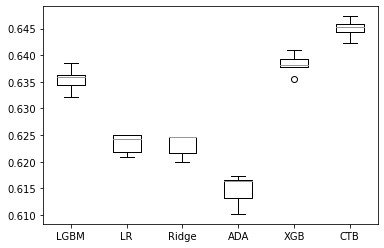

In [36]:
plt.boxplot(results_skf, labels=cv_models.keys())
plt.show()

In [26]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [27]:
cv_models = {'LGBM':LGBMClassifier(random_state=1), 'XGB':XGBClassifier(random_state=1), 
             'CTB':CatBoostClassifier(random_state=1)}

results_kf = []
for model in cv_models.values():
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kf)   # 35 min
    results_kf.append(cv_results)

Learning rate set to 0.128039
0:	learn: 0.6845645	total: 35.5ms	remaining: 35.4s
1:	learn: 0.6777946	total: 69.9ms	remaining: 34.9s
2:	learn: 0.6728709	total: 103ms	remaining: 34.4s
3:	learn: 0.6689468	total: 138ms	remaining: 34.3s
4:	learn: 0.6659114	total: 167ms	remaining: 33.2s
5:	learn: 0.6635079	total: 196ms	remaining: 32.4s
6:	learn: 0.6616171	total: 228ms	remaining: 32.4s
7:	learn: 0.6600993	total: 259ms	remaining: 32.2s
8:	learn: 0.6588504	total: 290ms	remaining: 32s
9:	learn: 0.6577882	total: 321ms	remaining: 31.8s
10:	learn: 0.6569337	total: 351ms	remaining: 31.6s
11:	learn: 0.6561878	total: 382ms	remaining: 31.4s
12:	learn: 0.6555395	total: 415ms	remaining: 31.5s
13:	learn: 0.6548979	total: 449ms	remaining: 31.6s
14:	learn: 0.6544588	total: 485ms	remaining: 31.9s
15:	learn: 0.6540725	total: 522ms	remaining: 32.1s
16:	learn: 0.6537530	total: 552ms	remaining: 31.9s
17:	learn: 0.6533942	total: 581ms	remaining: 31.7s
18:	learn: 0.6530160	total: 610ms	remaining: 31.5s
19:	learn: 

160:	learn: 0.6375237	total: 7.54s	remaining: 39.3s
161:	learn: 0.6374840	total: 7.58s	remaining: 39.2s
162:	learn: 0.6374275	total: 7.63s	remaining: 39.2s
163:	learn: 0.6373650	total: 7.69s	remaining: 39.2s
164:	learn: 0.6372957	total: 7.75s	remaining: 39.2s
165:	learn: 0.6372583	total: 7.81s	remaining: 39.2s
166:	learn: 0.6372258	total: 7.86s	remaining: 39.2s
167:	learn: 0.6371674	total: 7.91s	remaining: 39.2s
168:	learn: 0.6371083	total: 7.97s	remaining: 39.2s
169:	learn: 0.6370567	total: 8.04s	remaining: 39.2s
170:	learn: 0.6370058	total: 8.09s	remaining: 39.2s
171:	learn: 0.6369471	total: 8.14s	remaining: 39.2s
172:	learn: 0.6368849	total: 8.2s	remaining: 39.2s
173:	learn: 0.6368269	total: 8.26s	remaining: 39.2s
174:	learn: 0.6367702	total: 8.34s	remaining: 39.3s
175:	learn: 0.6367169	total: 8.42s	remaining: 39.4s
176:	learn: 0.6366766	total: 8.47s	remaining: 39.4s
177:	learn: 0.6366046	total: 8.53s	remaining: 39.4s
178:	learn: 0.6365323	total: 8.57s	remaining: 39.3s
179:	learn: 0

321:	learn: 0.6305244	total: 16.2s	remaining: 34s
322:	learn: 0.6305060	total: 16.2s	remaining: 34s
323:	learn: 0.6304587	total: 16.3s	remaining: 33.9s
324:	learn: 0.6304216	total: 16.3s	remaining: 33.9s
325:	learn: 0.6303913	total: 16.4s	remaining: 33.9s
326:	learn: 0.6303481	total: 16.5s	remaining: 33.9s
327:	learn: 0.6303239	total: 16.5s	remaining: 33.8s
328:	learn: 0.6302955	total: 16.6s	remaining: 33.8s
329:	learn: 0.6302597	total: 16.6s	remaining: 33.8s
330:	learn: 0.6302407	total: 16.7s	remaining: 33.7s
331:	learn: 0.6302069	total: 16.7s	remaining: 33.7s
332:	learn: 0.6301834	total: 16.8s	remaining: 33.6s
333:	learn: 0.6301612	total: 16.8s	remaining: 33.6s
334:	learn: 0.6301406	total: 16.9s	remaining: 33.5s
335:	learn: 0.6301041	total: 16.9s	remaining: 33.5s
336:	learn: 0.6300765	total: 17s	remaining: 33.4s
337:	learn: 0.6300382	total: 17s	remaining: 33.4s
338:	learn: 0.6299776	total: 17.1s	remaining: 33.3s
339:	learn: 0.6299513	total: 17.2s	remaining: 33.3s
340:	learn: 0.629924

482:	learn: 0.6256279	total: 25s	remaining: 26.8s
483:	learn: 0.6256029	total: 25.1s	remaining: 26.7s
484:	learn: 0.6255730	total: 25.1s	remaining: 26.7s
485:	learn: 0.6255510	total: 25.2s	remaining: 26.6s
486:	learn: 0.6255303	total: 25.2s	remaining: 26.6s
487:	learn: 0.6255049	total: 25.3s	remaining: 26.5s
488:	learn: 0.6254741	total: 25.3s	remaining: 26.5s
489:	learn: 0.6254471	total: 25.4s	remaining: 26.4s
490:	learn: 0.6254249	total: 25.4s	remaining: 26.4s
491:	learn: 0.6253961	total: 25.5s	remaining: 26.3s
492:	learn: 0.6253723	total: 25.6s	remaining: 26.3s
493:	learn: 0.6253442	total: 25.6s	remaining: 26.2s
494:	learn: 0.6253032	total: 25.7s	remaining: 26.2s
495:	learn: 0.6252843	total: 25.7s	remaining: 26.1s
496:	learn: 0.6252687	total: 25.8s	remaining: 26.1s
497:	learn: 0.6252363	total: 25.8s	remaining: 26s
498:	learn: 0.6252036	total: 25.9s	remaining: 26s
499:	learn: 0.6251858	total: 25.9s	remaining: 25.9s
500:	learn: 0.6251462	total: 26s	remaining: 25.9s
501:	learn: 0.625119

644:	learn: 0.6218099	total: 33.7s	remaining: 18.5s
645:	learn: 0.6217899	total: 33.7s	remaining: 18.5s
646:	learn: 0.6217786	total: 33.8s	remaining: 18.4s
647:	learn: 0.6217572	total: 33.8s	remaining: 18.4s
648:	learn: 0.6217402	total: 33.9s	remaining: 18.3s
649:	learn: 0.6217252	total: 34s	remaining: 18.3s
650:	learn: 0.6217135	total: 34s	remaining: 18.2s
651:	learn: 0.6216771	total: 34.1s	remaining: 18.2s
652:	learn: 0.6216559	total: 34.1s	remaining: 18.1s
653:	learn: 0.6216322	total: 34.2s	remaining: 18.1s
654:	learn: 0.6216078	total: 34.3s	remaining: 18.1s
655:	learn: 0.6215763	total: 34.3s	remaining: 18s
656:	learn: 0.6215474	total: 34.4s	remaining: 18s
657:	learn: 0.6215276	total: 34.5s	remaining: 17.9s
658:	learn: 0.6215157	total: 34.5s	remaining: 17.9s
659:	learn: 0.6214925	total: 34.6s	remaining: 17.8s
660:	learn: 0.6214770	total: 34.6s	remaining: 17.8s
661:	learn: 0.6214496	total: 34.7s	remaining: 17.7s
662:	learn: 0.6214345	total: 34.7s	remaining: 17.6s
663:	learn: 0.621411

803:	learn: 0.6186265	total: 42.3s	remaining: 10.3s
804:	learn: 0.6186020	total: 42.4s	remaining: 10.3s
805:	learn: 0.6185770	total: 42.5s	remaining: 10.2s
806:	learn: 0.6185591	total: 42.5s	remaining: 10.2s
807:	learn: 0.6185381	total: 42.6s	remaining: 10.1s
808:	learn: 0.6185177	total: 42.6s	remaining: 10.1s
809:	learn: 0.6184894	total: 42.7s	remaining: 10s
810:	learn: 0.6184735	total: 42.7s	remaining: 9.96s
811:	learn: 0.6184661	total: 42.8s	remaining: 9.9s
812:	learn: 0.6184512	total: 42.8s	remaining: 9.85s
813:	learn: 0.6184346	total: 42.9s	remaining: 9.79s
814:	learn: 0.6184087	total: 42.9s	remaining: 9.74s
815:	learn: 0.6183850	total: 43s	remaining: 9.69s
816:	learn: 0.6183723	total: 43s	remaining: 9.64s
817:	learn: 0.6183545	total: 43.1s	remaining: 9.59s
818:	learn: 0.6183380	total: 43.1s	remaining: 9.54s
819:	learn: 0.6183081	total: 43.2s	remaining: 9.48s
820:	learn: 0.6182889	total: 43.2s	remaining: 9.43s
821:	learn: 0.6182651	total: 43.3s	remaining: 9.38s
822:	learn: 0.61825

965:	learn: 0.6155882	total: 51.4s	remaining: 1.81s
966:	learn: 0.6155706	total: 51.5s	remaining: 1.76s
967:	learn: 0.6155445	total: 51.5s	remaining: 1.7s
968:	learn: 0.6155258	total: 51.6s	remaining: 1.65s
969:	learn: 0.6155107	total: 51.6s	remaining: 1.6s
970:	learn: 0.6154861	total: 51.7s	remaining: 1.54s
971:	learn: 0.6154714	total: 51.7s	remaining: 1.49s
972:	learn: 0.6154512	total: 51.8s	remaining: 1.44s
973:	learn: 0.6154440	total: 51.8s	remaining: 1.38s
974:	learn: 0.6154217	total: 51.9s	remaining: 1.33s
975:	learn: 0.6154097	total: 52s	remaining: 1.28s
976:	learn: 0.6153983	total: 52s	remaining: 1.22s
977:	learn: 0.6153893	total: 52.1s	remaining: 1.17s
978:	learn: 0.6153796	total: 52.2s	remaining: 1.12s
979:	learn: 0.6153627	total: 52.2s	remaining: 1.06s
980:	learn: 0.6153431	total: 52.3s	remaining: 1.01s
981:	learn: 0.6153364	total: 52.4s	remaining: 960ms
982:	learn: 0.6153131	total: 52.4s	remaining: 906ms
983:	learn: 0.6152959	total: 52.5s	remaining: 853ms
984:	learn: 0.6152

126:	learn: 0.6399721	total: 7.16s	remaining: 49.2s
127:	learn: 0.6398929	total: 7.22s	remaining: 49.2s
128:	learn: 0.6398273	total: 7.28s	remaining: 49.2s
129:	learn: 0.6397086	total: 7.34s	remaining: 49.2s
130:	learn: 0.6396430	total: 7.41s	remaining: 49.1s
131:	learn: 0.6395641	total: 7.47s	remaining: 49.1s
132:	learn: 0.6395014	total: 7.56s	remaining: 49.3s
133:	learn: 0.6394066	total: 7.62s	remaining: 49.3s
134:	learn: 0.6393185	total: 7.69s	remaining: 49.3s
135:	learn: 0.6392473	total: 7.77s	remaining: 49.4s
136:	learn: 0.6391827	total: 7.85s	remaining: 49.5s
137:	learn: 0.6391400	total: 7.94s	remaining: 49.6s
138:	learn: 0.6390516	total: 8.03s	remaining: 49.7s
139:	learn: 0.6389711	total: 8.11s	remaining: 49.8s
140:	learn: 0.6388908	total: 8.19s	remaining: 49.9s
141:	learn: 0.6388449	total: 8.24s	remaining: 49.8s
142:	learn: 0.6387932	total: 8.29s	remaining: 49.7s
143:	learn: 0.6387128	total: 8.34s	remaining: 49.6s
144:	learn: 0.6386365	total: 8.38s	remaining: 49.4s
145:	learn: 

285:	learn: 0.6318521	total: 16.3s	remaining: 40.7s
286:	learn: 0.6318059	total: 16.4s	remaining: 40.7s
287:	learn: 0.6317564	total: 16.4s	remaining: 40.6s
288:	learn: 0.6317328	total: 16.5s	remaining: 40.5s
289:	learn: 0.6317019	total: 16.5s	remaining: 40.5s
290:	learn: 0.6316746	total: 16.6s	remaining: 40.4s
291:	learn: 0.6316434	total: 16.6s	remaining: 40.3s
292:	learn: 0.6316233	total: 16.7s	remaining: 40.2s
293:	learn: 0.6315929	total: 16.7s	remaining: 40.2s
294:	learn: 0.6315645	total: 16.8s	remaining: 40.1s
295:	learn: 0.6315147	total: 16.9s	remaining: 40.1s
296:	learn: 0.6314852	total: 16.9s	remaining: 40s
297:	learn: 0.6314524	total: 17s	remaining: 40s
298:	learn: 0.6314327	total: 17.1s	remaining: 40s
299:	learn: 0.6313863	total: 17.1s	remaining: 39.9s
300:	learn: 0.6313574	total: 17.2s	remaining: 39.9s
301:	learn: 0.6313297	total: 17.2s	remaining: 39.9s
302:	learn: 0.6312972	total: 17.3s	remaining: 39.8s
303:	learn: 0.6312632	total: 17.4s	remaining: 39.8s
304:	learn: 0.631234

446:	learn: 0.6268204	total: 25.5s	remaining: 31.5s
447:	learn: 0.6267939	total: 25.5s	remaining: 31.4s
448:	learn: 0.6267673	total: 25.6s	remaining: 31.4s
449:	learn: 0.6267417	total: 25.6s	remaining: 31.3s
450:	learn: 0.6267073	total: 25.7s	remaining: 31.3s
451:	learn: 0.6266867	total: 25.7s	remaining: 31.2s
452:	learn: 0.6266537	total: 25.8s	remaining: 31.1s
453:	learn: 0.6266152	total: 25.8s	remaining: 31.1s
454:	learn: 0.6266002	total: 25.9s	remaining: 31s
455:	learn: 0.6265799	total: 26s	remaining: 31s
456:	learn: 0.6265580	total: 26s	remaining: 30.9s
457:	learn: 0.6265281	total: 26.1s	remaining: 30.9s
458:	learn: 0.6265133	total: 26.1s	remaining: 30.8s
459:	learn: 0.6264871	total: 26.2s	remaining: 30.7s
460:	learn: 0.6264726	total: 26.2s	remaining: 30.7s
461:	learn: 0.6264485	total: 26.3s	remaining: 30.6s
462:	learn: 0.6264227	total: 26.3s	remaining: 30.5s
463:	learn: 0.6263929	total: 26.4s	remaining: 30.5s
464:	learn: 0.6263815	total: 26.4s	remaining: 30.4s
465:	learn: 0.626350

609:	learn: 0.6227915	total: 34.6s	remaining: 22.1s
610:	learn: 0.6227529	total: 34.7s	remaining: 22.1s
611:	learn: 0.6227214	total: 34.7s	remaining: 22s
612:	learn: 0.6227004	total: 34.8s	remaining: 22s
613:	learn: 0.6226796	total: 34.9s	remaining: 21.9s
614:	learn: 0.6226679	total: 34.9s	remaining: 21.9s
615:	learn: 0.6226458	total: 35s	remaining: 21.8s
616:	learn: 0.6226344	total: 35s	remaining: 21.8s
617:	learn: 0.6226134	total: 35.1s	remaining: 21.7s
618:	learn: 0.6225844	total: 35.2s	remaining: 21.6s
619:	learn: 0.6225650	total: 35.2s	remaining: 21.6s
620:	learn: 0.6225439	total: 35.3s	remaining: 21.5s
621:	learn: 0.6225205	total: 35.3s	remaining: 21.5s
622:	learn: 0.6225061	total: 35.4s	remaining: 21.4s
623:	learn: 0.6224807	total: 35.4s	remaining: 21.4s
624:	learn: 0.6224526	total: 35.5s	remaining: 21.3s
625:	learn: 0.6224277	total: 35.6s	remaining: 21.2s
626:	learn: 0.6224042	total: 35.6s	remaining: 21.2s
627:	learn: 0.6223851	total: 35.7s	remaining: 21.1s
628:	learn: 0.622366

770:	learn: 0.6194966	total: 43.5s	remaining: 12.9s
771:	learn: 0.6194642	total: 43.6s	remaining: 12.9s
772:	learn: 0.6194427	total: 43.6s	remaining: 12.8s
773:	learn: 0.6194222	total: 43.7s	remaining: 12.8s
774:	learn: 0.6194069	total: 43.7s	remaining: 12.7s
775:	learn: 0.6193967	total: 43.8s	remaining: 12.6s
776:	learn: 0.6193678	total: 43.8s	remaining: 12.6s
777:	learn: 0.6193557	total: 43.9s	remaining: 12.5s
778:	learn: 0.6193354	total: 43.9s	remaining: 12.5s
779:	learn: 0.6193192	total: 44s	remaining: 12.4s
780:	learn: 0.6192938	total: 44.1s	remaining: 12.4s
781:	learn: 0.6192686	total: 44.1s	remaining: 12.3s
782:	learn: 0.6192547	total: 44.2s	remaining: 12.2s
783:	learn: 0.6192373	total: 44.2s	remaining: 12.2s
784:	learn: 0.6192217	total: 44.3s	remaining: 12.1s
785:	learn: 0.6192094	total: 44.4s	remaining: 12.1s
786:	learn: 0.6191821	total: 44.4s	remaining: 12s
787:	learn: 0.6191629	total: 44.5s	remaining: 12s
788:	learn: 0.6191438	total: 44.5s	remaining: 11.9s
789:	learn: 0.6191

932:	learn: 0.6164394	total: 52.9s	remaining: 3.8s
933:	learn: 0.6164150	total: 53s	remaining: 3.74s
934:	learn: 0.6164065	total: 53s	remaining: 3.69s
935:	learn: 0.6163893	total: 53.1s	remaining: 3.63s
936:	learn: 0.6163794	total: 53.1s	remaining: 3.57s
937:	learn: 0.6163676	total: 53.2s	remaining: 3.52s
938:	learn: 0.6163466	total: 53.2s	remaining: 3.46s
939:	learn: 0.6163254	total: 53.3s	remaining: 3.4s
940:	learn: 0.6163155	total: 53.4s	remaining: 3.35s
941:	learn: 0.6163017	total: 53.4s	remaining: 3.29s
942:	learn: 0.6162681	total: 53.5s	remaining: 3.23s
943:	learn: 0.6162486	total: 53.6s	remaining: 3.18s
944:	learn: 0.6162284	total: 53.6s	remaining: 3.12s
945:	learn: 0.6162196	total: 53.6s	remaining: 3.06s
946:	learn: 0.6161970	total: 53.7s	remaining: 3s
947:	learn: 0.6161801	total: 53.7s	remaining: 2.95s
948:	learn: 0.6161540	total: 53.8s	remaining: 2.89s
949:	learn: 0.6161303	total: 53.8s	remaining: 2.83s
950:	learn: 0.6161219	total: 53.9s	remaining: 2.78s
951:	learn: 0.6161052

93:	learn: 0.6420415	total: 4.02s	remaining: 38.7s
94:	learn: 0.6419881	total: 4.08s	remaining: 38.9s
95:	learn: 0.6419158	total: 4.14s	remaining: 39s
96:	learn: 0.6418468	total: 4.18s	remaining: 39s
97:	learn: 0.6417749	total: 4.24s	remaining: 39s
98:	learn: 0.6416751	total: 4.29s	remaining: 39.1s
99:	learn: 0.6415702	total: 4.34s	remaining: 39.1s
100:	learn: 0.6414896	total: 4.38s	remaining: 39s
101:	learn: 0.6413803	total: 4.43s	remaining: 39s
102:	learn: 0.6413172	total: 4.48s	remaining: 39s
103:	learn: 0.6412456	total: 4.54s	remaining: 39.1s
104:	learn: 0.6411268	total: 4.59s	remaining: 39.1s
105:	learn: 0.6410568	total: 4.65s	remaining: 39.2s
106:	learn: 0.6409859	total: 4.71s	remaining: 39.3s
107:	learn: 0.6409392	total: 4.75s	remaining: 39.2s
108:	learn: 0.6408516	total: 4.81s	remaining: 39.3s
109:	learn: 0.6407374	total: 4.87s	remaining: 39.4s
110:	learn: 0.6406865	total: 4.92s	remaining: 39.4s
111:	learn: 0.6405682	total: 4.98s	remaining: 39.5s
112:	learn: 0.6404747	total: 5.

255:	learn: 0.6324470	total: 12.8s	remaining: 37.2s
256:	learn: 0.6323957	total: 12.9s	remaining: 37.2s
257:	learn: 0.6323552	total: 12.9s	remaining: 37.2s
258:	learn: 0.6323230	total: 13s	remaining: 37.1s
259:	learn: 0.6322952	total: 13s	remaining: 37.1s
260:	learn: 0.6322647	total: 13.1s	remaining: 37s
261:	learn: 0.6322196	total: 13.1s	remaining: 37s
262:	learn: 0.6321685	total: 13.2s	remaining: 37s
263:	learn: 0.6321405	total: 13.3s	remaining: 37s
264:	learn: 0.6321002	total: 13.3s	remaining: 37s
265:	learn: 0.6320616	total: 13.4s	remaining: 36.9s
266:	learn: 0.6320281	total: 13.4s	remaining: 36.9s
267:	learn: 0.6320015	total: 13.5s	remaining: 36.9s
268:	learn: 0.6319579	total: 13.6s	remaining: 36.9s
269:	learn: 0.6319395	total: 13.6s	remaining: 36.8s
270:	learn: 0.6319179	total: 13.7s	remaining: 36.8s
271:	learn: 0.6318675	total: 13.7s	remaining: 36.7s
272:	learn: 0.6318265	total: 13.8s	remaining: 36.7s
273:	learn: 0.6317881	total: 13.8s	remaining: 36.6s
274:	learn: 0.6317450	tota

417:	learn: 0.6270354	total: 21.5s	remaining: 29.9s
418:	learn: 0.6270033	total: 21.5s	remaining: 29.9s
419:	learn: 0.6269802	total: 21.6s	remaining: 29.8s
420:	learn: 0.6269334	total: 21.6s	remaining: 29.8s
421:	learn: 0.6269011	total: 21.7s	remaining: 29.7s
422:	learn: 0.6268868	total: 21.8s	remaining: 29.7s
423:	learn: 0.6268531	total: 21.8s	remaining: 29.6s
424:	learn: 0.6268225	total: 21.9s	remaining: 29.6s
425:	learn: 0.6267976	total: 21.9s	remaining: 29.5s
426:	learn: 0.6267587	total: 22s	remaining: 29.5s
427:	learn: 0.6267355	total: 22s	remaining: 29.4s
428:	learn: 0.6267090	total: 22.1s	remaining: 29.4s
429:	learn: 0.6266838	total: 22.1s	remaining: 29.3s
430:	learn: 0.6266485	total: 22.2s	remaining: 29.3s
431:	learn: 0.6266176	total: 22.2s	remaining: 29.2s
432:	learn: 0.6265844	total: 22.3s	remaining: 29.2s
433:	learn: 0.6265629	total: 22.3s	remaining: 29.1s
434:	learn: 0.6265361	total: 22.4s	remaining: 29.1s
435:	learn: 0.6265083	total: 22.4s	remaining: 29s
436:	learn: 0.6264

576:	learn: 0.6231043	total: 29.8s	remaining: 21.9s
577:	learn: 0.6230905	total: 29.9s	remaining: 21.8s
578:	learn: 0.6230618	total: 29.9s	remaining: 21.8s
579:	learn: 0.6230340	total: 30s	remaining: 21.7s
580:	learn: 0.6230117	total: 30s	remaining: 21.6s
581:	learn: 0.6229757	total: 30.1s	remaining: 21.6s
582:	learn: 0.6229567	total: 30.1s	remaining: 21.5s
583:	learn: 0.6229292	total: 30.2s	remaining: 21.5s
584:	learn: 0.6229034	total: 30.2s	remaining: 21.4s
585:	learn: 0.6228720	total: 30.3s	remaining: 21.4s
586:	learn: 0.6228520	total: 30.3s	remaining: 21.3s
587:	learn: 0.6228228	total: 30.4s	remaining: 21.3s
588:	learn: 0.6227955	total: 30.4s	remaining: 21.2s
589:	learn: 0.6227691	total: 30.5s	remaining: 21.2s
590:	learn: 0.6227472	total: 30.6s	remaining: 21.1s
591:	learn: 0.6227297	total: 30.6s	remaining: 21.1s
592:	learn: 0.6227036	total: 30.6s	remaining: 21s
593:	learn: 0.6226848	total: 30.7s	remaining: 21s
594:	learn: 0.6226605	total: 30.7s	remaining: 20.9s
595:	learn: 0.622635

737:	learn: 0.6196021	total: 38.3s	remaining: 13.6s
738:	learn: 0.6195703	total: 38.3s	remaining: 13.5s
739:	learn: 0.6195416	total: 38.4s	remaining: 13.5s
740:	learn: 0.6195144	total: 38.5s	remaining: 13.4s
741:	learn: 0.6194879	total: 38.5s	remaining: 13.4s
742:	learn: 0.6194710	total: 38.6s	remaining: 13.3s
743:	learn: 0.6194594	total: 38.6s	remaining: 13.3s
744:	learn: 0.6194408	total: 38.7s	remaining: 13.2s
745:	learn: 0.6194094	total: 38.7s	remaining: 13.2s
746:	learn: 0.6193865	total: 38.8s	remaining: 13.1s
747:	learn: 0.6193689	total: 38.8s	remaining: 13.1s
748:	learn: 0.6193356	total: 38.9s	remaining: 13s
749:	learn: 0.6193150	total: 39s	remaining: 13s
750:	learn: 0.6192815	total: 39s	remaining: 12.9s
751:	learn: 0.6192521	total: 39.1s	remaining: 12.9s
752:	learn: 0.6192384	total: 39.1s	remaining: 12.8s
753:	learn: 0.6192150	total: 39.2s	remaining: 12.8s
754:	learn: 0.6191952	total: 39.3s	remaining: 12.7s
755:	learn: 0.6191822	total: 39.3s	remaining: 12.7s
756:	learn: 0.619160

897:	learn: 0.6164041	total: 47.5s	remaining: 5.39s
898:	learn: 0.6163817	total: 47.5s	remaining: 5.34s
899:	learn: 0.6163582	total: 47.6s	remaining: 5.29s
900:	learn: 0.6163426	total: 47.6s	remaining: 5.23s
901:	learn: 0.6163239	total: 47.7s	remaining: 5.18s
902:	learn: 0.6163067	total: 47.7s	remaining: 5.13s
903:	learn: 0.6162957	total: 47.8s	remaining: 5.07s
904:	learn: 0.6162829	total: 47.8s	remaining: 5.02s
905:	learn: 0.6162644	total: 47.9s	remaining: 4.97s
906:	learn: 0.6162477	total: 47.9s	remaining: 4.91s
907:	learn: 0.6162251	total: 48s	remaining: 4.86s
908:	learn: 0.6162097	total: 48s	remaining: 4.81s
909:	learn: 0.6161897	total: 48.1s	remaining: 4.75s
910:	learn: 0.6161667	total: 48.1s	remaining: 4.7s
911:	learn: 0.6161433	total: 48.2s	remaining: 4.65s
912:	learn: 0.6161245	total: 48.2s	remaining: 4.59s
913:	learn: 0.6161007	total: 48.3s	remaining: 4.54s
914:	learn: 0.6160903	total: 48.3s	remaining: 4.49s
915:	learn: 0.6160712	total: 48.4s	remaining: 4.43s
916:	learn: 0.616

57:	learn: 0.6452974	total: 3.38s	remaining: 55s
58:	learn: 0.6452017	total: 3.44s	remaining: 54.9s
59:	learn: 0.6450415	total: 3.51s	remaining: 55s
60:	learn: 0.6449507	total: 3.56s	remaining: 54.8s
61:	learn: 0.6448240	total: 3.61s	remaining: 54.6s
62:	learn: 0.6447054	total: 3.66s	remaining: 54.4s
63:	learn: 0.6446113	total: 3.71s	remaining: 54.2s
64:	learn: 0.6445315	total: 3.76s	remaining: 54.1s
65:	learn: 0.6443984	total: 3.81s	remaining: 53.9s
66:	learn: 0.6442822	total: 3.86s	remaining: 53.8s
67:	learn: 0.6442008	total: 3.92s	remaining: 53.8s
68:	learn: 0.6441081	total: 3.98s	remaining: 53.7s
69:	learn: 0.6440224	total: 4.03s	remaining: 53.5s
70:	learn: 0.6439400	total: 4.09s	remaining: 53.5s
71:	learn: 0.6438013	total: 4.14s	remaining: 53.4s
72:	learn: 0.6437026	total: 4.19s	remaining: 53.3s
73:	learn: 0.6436050	total: 4.26s	remaining: 53.3s
74:	learn: 0.6435192	total: 4.32s	remaining: 53.2s
75:	learn: 0.6434450	total: 4.37s	remaining: 53.1s
76:	learn: 0.6433578	total: 4.42s	r

217:	learn: 0.6339850	total: 12.1s	remaining: 43.3s
218:	learn: 0.6339342	total: 12.1s	remaining: 43.3s
219:	learn: 0.6338904	total: 12.2s	remaining: 43.2s
220:	learn: 0.6338348	total: 12.2s	remaining: 43.1s
221:	learn: 0.6338045	total: 12.3s	remaining: 43.1s
222:	learn: 0.6337623	total: 12.3s	remaining: 43s
223:	learn: 0.6337169	total: 12.4s	remaining: 42.9s
224:	learn: 0.6336660	total: 12.5s	remaining: 42.9s
225:	learn: 0.6336189	total: 12.5s	remaining: 42.8s
226:	learn: 0.6335872	total: 12.6s	remaining: 42.8s
227:	learn: 0.6335294	total: 12.6s	remaining: 42.7s
228:	learn: 0.6334922	total: 12.7s	remaining: 42.7s
229:	learn: 0.6334427	total: 12.7s	remaining: 42.6s
230:	learn: 0.6334004	total: 12.8s	remaining: 42.6s
231:	learn: 0.6333502	total: 12.8s	remaining: 42.5s
232:	learn: 0.6333102	total: 12.9s	remaining: 42.5s
233:	learn: 0.6332729	total: 12.9s	remaining: 42.4s
234:	learn: 0.6332278	total: 13s	remaining: 42.3s
235:	learn: 0.6331750	total: 13s	remaining: 42.2s
236:	learn: 0.6331

379:	learn: 0.6278805	total: 20.7s	remaining: 33.7s
380:	learn: 0.6278516	total: 20.7s	remaining: 33.7s
381:	learn: 0.6278286	total: 20.8s	remaining: 33.6s
382:	learn: 0.6278084	total: 20.8s	remaining: 33.6s
383:	learn: 0.6277790	total: 20.9s	remaining: 33.5s
384:	learn: 0.6277482	total: 20.9s	remaining: 33.4s
385:	learn: 0.6277065	total: 21s	remaining: 33.4s
386:	learn: 0.6276739	total: 21.1s	remaining: 33.3s
387:	learn: 0.6276512	total: 21.1s	remaining: 33.3s
388:	learn: 0.6276215	total: 21.2s	remaining: 33.2s
389:	learn: 0.6275852	total: 21.2s	remaining: 33.2s
390:	learn: 0.6275766	total: 21.2s	remaining: 33.1s
391:	learn: 0.6275553	total: 21.3s	remaining: 33s
392:	learn: 0.6275141	total: 21.4s	remaining: 33s
393:	learn: 0.6274947	total: 21.4s	remaining: 32.9s
394:	learn: 0.6274824	total: 21.4s	remaining: 32.8s
395:	learn: 0.6274385	total: 21.5s	remaining: 32.8s
396:	learn: 0.6274093	total: 21.5s	remaining: 32.7s
397:	learn: 0.6273701	total: 21.6s	remaining: 32.6s
398:	learn: 0.6273

540:	learn: 0.6235051	total: 30s	remaining: 25.4s
541:	learn: 0.6234752	total: 30s	remaining: 25.4s
542:	learn: 0.6234519	total: 30.1s	remaining: 25.3s
543:	learn: 0.6234290	total: 30.2s	remaining: 25.3s
544:	learn: 0.6234081	total: 30.2s	remaining: 25.2s
545:	learn: 0.6233935	total: 30.3s	remaining: 25.2s
546:	learn: 0.6233772	total: 30.3s	remaining: 25.1s
547:	learn: 0.6233552	total: 30.4s	remaining: 25s
548:	learn: 0.6233322	total: 30.4s	remaining: 25s
549:	learn: 0.6233150	total: 30.5s	remaining: 24.9s
550:	learn: 0.6232901	total: 30.6s	remaining: 24.9s
551:	learn: 0.6232565	total: 30.6s	remaining: 24.8s
552:	learn: 0.6232299	total: 30.7s	remaining: 24.8s
553:	learn: 0.6232081	total: 30.7s	remaining: 24.8s
554:	learn: 0.6231737	total: 30.8s	remaining: 24.7s
555:	learn: 0.6231506	total: 30.9s	remaining: 24.6s
556:	learn: 0.6231230	total: 30.9s	remaining: 24.6s
557:	learn: 0.6231044	total: 31s	remaining: 24.5s
558:	learn: 0.6230925	total: 31s	remaining: 24.5s
559:	learn: 0.6230813	to

701:	learn: 0.6199504	total: 38.8s	remaining: 16.5s
702:	learn: 0.6199286	total: 38.8s	remaining: 16.4s
703:	learn: 0.6199053	total: 38.9s	remaining: 16.3s
704:	learn: 0.6198705	total: 38.9s	remaining: 16.3s
705:	learn: 0.6198411	total: 39s	remaining: 16.2s
706:	learn: 0.6198252	total: 39s	remaining: 16.2s
707:	learn: 0.6198126	total: 39.1s	remaining: 16.1s
708:	learn: 0.6198010	total: 39.1s	remaining: 16.1s
709:	learn: 0.6197893	total: 39.2s	remaining: 16s
710:	learn: 0.6197645	total: 39.2s	remaining: 15.9s
711:	learn: 0.6197349	total: 39.3s	remaining: 15.9s
712:	learn: 0.6197256	total: 39.3s	remaining: 15.8s
713:	learn: 0.6196966	total: 39.4s	remaining: 15.8s
714:	learn: 0.6196734	total: 39.4s	remaining: 15.7s
715:	learn: 0.6196447	total: 39.5s	remaining: 15.6s
716:	learn: 0.6196147	total: 39.5s	remaining: 15.6s
717:	learn: 0.6195866	total: 39.6s	remaining: 15.5s
718:	learn: 0.6195575	total: 39.6s	remaining: 15.5s
719:	learn: 0.6195309	total: 39.7s	remaining: 15.4s
720:	learn: 0.6195

862:	learn: 0.6167136	total: 47.4s	remaining: 7.53s
863:	learn: 0.6166902	total: 47.5s	remaining: 7.47s
864:	learn: 0.6166693	total: 47.5s	remaining: 7.42s
865:	learn: 0.6166501	total: 47.6s	remaining: 7.36s
866:	learn: 0.6166195	total: 47.6s	remaining: 7.3s
867:	learn: 0.6166045	total: 47.7s	remaining: 7.25s
868:	learn: 0.6165915	total: 47.7s	remaining: 7.19s
869:	learn: 0.6165759	total: 47.8s	remaining: 7.14s
870:	learn: 0.6165673	total: 47.8s	remaining: 7.08s
871:	learn: 0.6165403	total: 47.9s	remaining: 7.03s
872:	learn: 0.6165284	total: 47.9s	remaining: 6.97s
873:	learn: 0.6165119	total: 48s	remaining: 6.92s
874:	learn: 0.6164934	total: 48.1s	remaining: 6.87s
875:	learn: 0.6164727	total: 48.1s	remaining: 6.81s
876:	learn: 0.6164435	total: 48.2s	remaining: 6.75s
877:	learn: 0.6164326	total: 48.2s	remaining: 6.7s
878:	learn: 0.6164236	total: 48.3s	remaining: 6.64s
879:	learn: 0.6164004	total: 48.3s	remaining: 6.59s
880:	learn: 0.6163819	total: 48.4s	remaining: 6.54s
881:	learn: 0.61

23:	learn: 0.6509801	total: 707ms	remaining: 28.8s
24:	learn: 0.6507446	total: 732ms	remaining: 28.6s
25:	learn: 0.6505549	total: 761ms	remaining: 28.5s
26:	learn: 0.6503178	total: 791ms	remaining: 28.5s
27:	learn: 0.6500979	total: 822ms	remaining: 28.5s
28:	learn: 0.6499003	total: 850ms	remaining: 28.5s
29:	learn: 0.6496875	total: 879ms	remaining: 28.4s
30:	learn: 0.6494445	total: 905ms	remaining: 28.3s
31:	learn: 0.6492323	total: 937ms	remaining: 28.3s
32:	learn: 0.6490073	total: 969ms	remaining: 28.4s
33:	learn: 0.6488374	total: 1s	remaining: 28.5s
34:	learn: 0.6486594	total: 1.04s	remaining: 28.6s
35:	learn: 0.6484971	total: 1.07s	remaining: 28.8s
36:	learn: 0.6483560	total: 1.11s	remaining: 28.8s
37:	learn: 0.6481379	total: 1.14s	remaining: 28.9s
38:	learn: 0.6479211	total: 1.18s	remaining: 29s
39:	learn: 0.6477982	total: 1.21s	remaining: 29.1s
40:	learn: 0.6476837	total: 1.25s	remaining: 29.2s
41:	learn: 0.6475117	total: 1.29s	remaining: 29.4s
42:	learn: 0.6473478	total: 1.32s	re

185:	learn: 0.6356564	total: 9.14s	remaining: 40s
186:	learn: 0.6356024	total: 9.2s	remaining: 40s
187:	learn: 0.6355328	total: 9.25s	remaining: 40s
188:	learn: 0.6354988	total: 9.31s	remaining: 40s
189:	learn: 0.6354575	total: 9.37s	remaining: 39.9s
190:	learn: 0.6354256	total: 9.42s	remaining: 39.9s
191:	learn: 0.6353545	total: 9.48s	remaining: 39.9s
192:	learn: 0.6352831	total: 9.53s	remaining: 39.9s
193:	learn: 0.6352111	total: 9.6s	remaining: 39.9s
194:	learn: 0.6351914	total: 9.66s	remaining: 39.9s
195:	learn: 0.6351639	total: 9.72s	remaining: 39.9s
196:	learn: 0.6351248	total: 9.78s	remaining: 39.9s
197:	learn: 0.6350542	total: 9.84s	remaining: 39.9s
198:	learn: 0.6350232	total: 9.9s	remaining: 39.9s
199:	learn: 0.6349579	total: 9.96s	remaining: 39.8s
200:	learn: 0.6349034	total: 10s	remaining: 39.8s
201:	learn: 0.6348674	total: 10.1s	remaining: 39.7s
202:	learn: 0.6348042	total: 10.1s	remaining: 39.7s
203:	learn: 0.6347712	total: 10.2s	remaining: 39.6s
204:	learn: 0.6347284	tot

347:	learn: 0.6291497	total: 18.1s	remaining: 33.8s
348:	learn: 0.6291148	total: 18.1s	remaining: 33.8s
349:	learn: 0.6290979	total: 18.2s	remaining: 33.7s
350:	learn: 0.6290551	total: 18.2s	remaining: 33.7s
351:	learn: 0.6290231	total: 18.3s	remaining: 33.6s
352:	learn: 0.6289882	total: 18.3s	remaining: 33.6s
353:	learn: 0.6289724	total: 18.4s	remaining: 33.5s
354:	learn: 0.6289332	total: 18.4s	remaining: 33.5s
355:	learn: 0.6289028	total: 18.5s	remaining: 33.4s
356:	learn: 0.6288596	total: 18.5s	remaining: 33.4s
357:	learn: 0.6287993	total: 18.6s	remaining: 33.3s
358:	learn: 0.6287729	total: 18.6s	remaining: 33.3s
359:	learn: 0.6287411	total: 18.7s	remaining: 33.2s
360:	learn: 0.6287083	total: 18.7s	remaining: 33.2s
361:	learn: 0.6286659	total: 18.8s	remaining: 33.1s
362:	learn: 0.6286520	total: 18.8s	remaining: 33.1s
363:	learn: 0.6286122	total: 18.9s	remaining: 33s
364:	learn: 0.6285735	total: 18.9s	remaining: 33s
365:	learn: 0.6285454	total: 19s	remaining: 32.9s
366:	learn: 0.6285

510:	learn: 0.6245705	total: 26.9s	remaining: 25.7s
511:	learn: 0.6245601	total: 26.9s	remaining: 25.7s
512:	learn: 0.6245327	total: 27s	remaining: 25.6s
513:	learn: 0.6245150	total: 27s	remaining: 25.6s
514:	learn: 0.6244925	total: 27.1s	remaining: 25.5s
515:	learn: 0.6244738	total: 27.2s	remaining: 25.5s
516:	learn: 0.6244450	total: 27.2s	remaining: 25.4s
517:	learn: 0.6244259	total: 27.3s	remaining: 25.4s
518:	learn: 0.6244023	total: 27.3s	remaining: 25.3s
519:	learn: 0.6243763	total: 27.4s	remaining: 25.3s
520:	learn: 0.6243445	total: 27.5s	remaining: 25.2s
521:	learn: 0.6243237	total: 27.5s	remaining: 25.2s
522:	learn: 0.6243005	total: 27.6s	remaining: 25.2s
523:	learn: 0.6242745	total: 27.6s	remaining: 25.1s
524:	learn: 0.6242426	total: 27.7s	remaining: 25.1s
525:	learn: 0.6242234	total: 27.8s	remaining: 25s
526:	learn: 0.6241961	total: 27.8s	remaining: 25s
527:	learn: 0.6241848	total: 27.9s	remaining: 24.9s
528:	learn: 0.6241544	total: 27.9s	remaining: 24.8s
529:	learn: 0.624144

671:	learn: 0.6209924	total: 35.5s	remaining: 17.3s
672:	learn: 0.6209664	total: 35.6s	remaining: 17.3s
673:	learn: 0.6209418	total: 35.7s	remaining: 17.2s
674:	learn: 0.6209184	total: 35.7s	remaining: 17.2s
675:	learn: 0.6208978	total: 35.8s	remaining: 17.1s
676:	learn: 0.6208773	total: 35.8s	remaining: 17.1s
677:	learn: 0.6208652	total: 35.9s	remaining: 17s
678:	learn: 0.6208496	total: 35.9s	remaining: 17s
679:	learn: 0.6208397	total: 36s	remaining: 16.9s
680:	learn: 0.6208168	total: 36s	remaining: 16.9s
681:	learn: 0.6207824	total: 36.1s	remaining: 16.8s
682:	learn: 0.6207653	total: 36.1s	remaining: 16.8s
683:	learn: 0.6207373	total: 36.2s	remaining: 16.7s
684:	learn: 0.6207188	total: 36.2s	remaining: 16.7s
685:	learn: 0.6207013	total: 36.3s	remaining: 16.6s
686:	learn: 0.6206847	total: 36.3s	remaining: 16.6s
687:	learn: 0.6206625	total: 36.4s	remaining: 16.5s
688:	learn: 0.6206389	total: 36.4s	remaining: 16.4s
689:	learn: 0.6206173	total: 36.5s	remaining: 16.4s
690:	learn: 0.620608

833:	learn: 0.6178033	total: 44.2s	remaining: 8.81s
834:	learn: 0.6177831	total: 44.3s	remaining: 8.75s
835:	learn: 0.6177701	total: 44.3s	remaining: 8.7s
836:	learn: 0.6177457	total: 44.4s	remaining: 8.65s
837:	learn: 0.6177291	total: 44.5s	remaining: 8.59s
838:	learn: 0.6176979	total: 44.5s	remaining: 8.54s
839:	learn: 0.6176841	total: 44.6s	remaining: 8.49s
840:	learn: 0.6176525	total: 44.6s	remaining: 8.43s
841:	learn: 0.6176271	total: 44.7s	remaining: 8.38s
842:	learn: 0.6176142	total: 44.7s	remaining: 8.33s
843:	learn: 0.6176052	total: 44.8s	remaining: 8.28s
844:	learn: 0.6175800	total: 44.8s	remaining: 8.22s
845:	learn: 0.6175558	total: 44.9s	remaining: 8.17s
846:	learn: 0.6175376	total: 44.9s	remaining: 8.12s
847:	learn: 0.6175221	total: 45s	remaining: 8.06s
848:	learn: 0.6175055	total: 45s	remaining: 8.01s
849:	learn: 0.6174947	total: 45.1s	remaining: 7.96s
850:	learn: 0.6174721	total: 45.1s	remaining: 7.9s
851:	learn: 0.6174466	total: 45.2s	remaining: 7.85s
852:	learn: 0.6174

993:	learn: 0.6147840	total: 52.9s	remaining: 319ms
994:	learn: 0.6147586	total: 52.9s	remaining: 266ms
995:	learn: 0.6147432	total: 53s	remaining: 213ms
996:	learn: 0.6147234	total: 53s	remaining: 160ms
997:	learn: 0.6147116	total: 53.1s	remaining: 106ms
998:	learn: 0.6146906	total: 53.1s	remaining: 53.2ms
999:	learn: 0.6146702	total: 53.2s	remaining: 0us


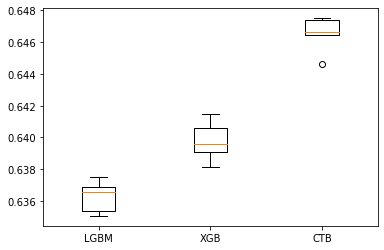

In [28]:
plt.boxplot(results_kf, labels=cv_models.keys())
plt.show()

## hyperparameter tuning with optuna

### XGB hyperparameter tuning

In [29]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'n_jobs': -1,
        'random_state':1,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [30]:
study = optuna.create_study(direction='maximize')

[I 2023-03-27 18:06:05,982] A new study created in memory with name: no-name-13b04abe-31b4-457a-8e53-663d08d16f32


In [31]:
study.optimize(objective, n_trials=100) # 18:07 21:07

C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-27 18:14:36,354] Trial 3 finished with value: 0.6130870977976652 and parameters: {'max_depth': 1, 'learning_rate': 0.09363362264799367, 'n_estimators': 318, 'min_child_weight': 8, 'gamma': 0.8132396699339164, 'subsample': 0.0116323049821415, 'colsample_bytree': 0.0385993889772625, 'reg_alpha': 0.00011028658550798038, 'reg_lambda': 4.2476681491817674e-05}. Best is trial 0 with value: 0.6249576053302408.
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-27 18:32:10,602] Trial 10 finished with value: 0.6139185803529424 and parameters: {'max_depth': 9, 'learning_rate': 0.011652887869691014, 'n_estimators': 477, 'min_child_weight': 3, 'gamma': 6.334152215561391e-07, 'subsample': 0.9404687324396658, 'colsample_bytree': 0.09882423542978096, 'reg_alpha': 0.3513370002890532, 'reg_lambda': 0.8775451846480251}. Best is trial 6 with value: 0.6283382383510389.
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-27 18:57:43,298] Trial 17 finished with value: 0.6340492106386005 and parameters: {'max_depth': 3, 'learning_rate': 0.5174270123336889, 'n_estimators': 491, 'min_child_weight': 5, 'gamma': 0.009446116783769243, 'subsample': 0.22051834353126468, 'colsample_bytree': 0.4432136822230057, 'reg_alpha': 0.016130782171297774, 'reg_lambda': 0.005510579394405049}. Best is trial 17 with value: 0.6340492106386005.
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[I 2023-03-27 20:16:13,510] Trial 24 finished with value: 0.635241731671827 and parameters: {'max_depth': 2, 'learning_rate': 0.37664585443973486, 'n_estimators': 424, 'min_child_weight': 7, 'gamma': 0.13433515434196877, 'subsample': 0.5172641583087277, 'colsample_bytree': 0.9695738040272525, 'reg_alpha': 1.4176882945328262e-05, 'reg_lambda': 1.2478345263886732e-08}. Best is trial 21 with value: 0.6365655394243077.
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.su

[W 2023-03-27 21:08:32,151] Trial 31 failed with parameters: {'max_depth': 6, 'learning_rate': 0.16978809625293964, 'n_estimators': 391, 'min_child_weight': 9, 'gamma': 0.0024398757640294337, 'subsample': 0.11645727935643059, 'colsample_bytree': 0.37014135517754265, 'reg_alpha': 1.1174338333889293e-06, 'reg_lambda': 4.390959171164437e-07} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_11232\2939489719.py", line 22, in objective
    optuna_model.fit(X_train, y_train)
  File "C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1516, in fit
    self._Booster = train(
  File "C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py", line 620, in

KeyboardInterrupt: 

In [32]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 32
Best trial:
  Value: 0.6457337286522324
  Params: 
    max_depth: 6
    learning_rate: 0.3517318382187914
    n_estimators: 453
    min_child_weight: 10
    gamma: 0.0057213543682698735
    subsample: 0.3512181952788958
    colsample_bytree: 0.4695116928871539
    reg_alpha: 2.4938354408668175e-06
    reg_lambda: 2.5126825116176996e-07


## LGBM Classifier hyperparameters tunig using optuna

In [82]:
def objective_lgbm(trial):
    """Define the objective function"""

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "num_classes": 2,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'random_state':1
    }

    # Fit the model
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [83]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)

[I 2023-03-28 19:57:09,434] A new study created in memory with name: lightgbm


In [84]:
study.optimize(objective_lgbm, n_trials=30)

[W 2023-03-28 19:57:31,277] Trial 0 failed with parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22} because of the following error: ValueError('y contains previously unseen labels: [  932 92335]').
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_4428\3579054113.py", line 25, in objective_lgbm
    y_pred = optuna_model.predict(X_test)
  File "C:\Users\HP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 990, in predict
    return self._le.inverse_transform(class_index)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py", line 161, in inverse_transform
    raise ValueError("y contains previously unseen labels: %s" %

ValueError: y contains previously unseen labels: [  932 92335]

In [89]:
param_grid_LGBM = {'learning_rate': [0.01, 0.1],
                 'n_estimators': [200, 300],
                 'max_depth': [4, 5],
                 'random_state': [1]
                }

lgbm = LGBMClassifier(class_weight={0:37.2, 1:62.8})
grid_LGBM = GridSearchCV(lgbm, param_grid_LGBM, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_LGBM.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(class_weight={0: 37.2, 1: 62.8}),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 5],
                         'n_estimators': [200, 300], 'random_state': [1]},
             scoring='roc_auc', verbose=1)

In [90]:
grid_LGBM.best_estimator_

LGBMClassifier(class_weight={0: 37.2, 1: 62.8}, max_depth=5, n_estimators=300,
               random_state=1)

In [91]:
# create a model with best parameters
grid_lgbm_results_test = grid_LGBM.best_estimator_.predict(X_test)

print('ROC AUC score in test set: {:.3f}'.format(roc_auc_score(y_test, grid_lgbm_results_test)))

confusion_matrix(y_test, grid_lgbm_results_test)

ROC AUC score in test set: 0.608


array([[26993, 27747],
       [10140, 26523]], dtype=int64)

## CatBoost hyperparameters tunig using optuna

In [31]:
def objective_cat(trial):
    """Define the objective function"""

    params = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'random_state': 1,
        'verbose':False
    }

    # Fit the model
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [32]:
study = optuna.create_study(direction='maximize')

[I 2023-03-28 17:40:32,217] A new study created in memory with name: no-name-6c207417-fff0-4f28-988b-db18de2bd9a0


In [33]:
study.optimize(objective_cat, n_trials=30)

[I 2023-03-28 17:41:06,820] Trial 0 finished with value: 0.6210299443125499 and parameters: {'iterations': 295, 'learning_rate': 0.008703315471224054, 'depth': 7, 'l2_leaf_reg': 4.564882641019163e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3635972815555149e-07, 'bagging_temperature': 0.9380135435888504, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 0 with value: 0.6210299443125499.
[I 2023-03-28 17:41:29,883] Trial 1 finished with value: 0.6163583252190847 and parameters: {'iterations': 244, 'learning_rate': 0.016600685389897358, 'depth': 8, 'l2_leaf_reg': 2.323759927640521, 'bootstrap_type': 'Bayesian', 'random_strength': 3.835564263706413e-07, 'bagging_temperature': 4.762314064076226, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 0 with value: 0.6210299443125499.
[I 2023-03-28 17:42:02,081] Trial 2 finished with value: 0.6306904587376782 and parameters: {'iterations': 401, 'learning_rate': 0.0629488864876641, 'depth': 7, 'l2_leaf_reg': 5.01732671040233, 'bootstr

[I 2023-03-28 18:00:47,901] Trial 21 finished with value: 0.6447709593777009 and parameters: {'iterations': 702, 'learning_rate': 0.09709609884775496, 'depth': 10, 'l2_leaf_reg': 0.003054292478428288, 'bootstrap_type': 'Bayesian', 'random_strength': 0.8502445671629438, 'bagging_temperature': 3.79753723227517, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 21 with value: 0.6447709593777009.
[I 2023-03-28 18:03:10,166] Trial 22 finished with value: 0.6416091375556601 and parameters: {'iterations': 687, 'learning_rate': 0.05782330329870871, 'depth': 10, 'l2_leaf_reg': 0.001959446016520782, 'bootstrap_type': 'Bayesian', 'random_strength': 0.9077913693198093, 'bagging_temperature': 3.971171329869049, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 21 with value: 0.6447709593777009.
[I 2023-03-28 18:06:07,073] Trial 23 finished with value: 0.6430095292277058 and parameters: {'iterations': 896, 'learning_rate': 0.05953014744884925, 'depth': 10, 'l2_leaf_reg': 0.0026694747691356547, 'bootst

In [35]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 30
Best trial:
  Value: 0.6447709593777009
  Params: 
    iterations: 702
    learning_rate: 0.09709609884775496
    depth: 10
    l2_leaf_reg: 0.003054292478428288
    bootstrap_type: Bayesian
    random_strength: 0.8502445671629438
    bagging_temperature: 3.79753723227517
    od_type: Iter
    od_wait: 43


In [36]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_cat_optuna = CatBoostClassifier(**params)
model_cat_optuna.fit(X_train, y_train)

cat_results_optuna = model_cat_optuna.predict(X_test)

confusion_matrix(y_test, cat_results_optuna)

0:	learn: 0.6865180	total: 258ms	remaining: 3m
1:	learn: 0.6805912	total: 526ms	remaining: 3m 4s
2:	learn: 0.6761227	total: 769ms	remaining: 2m 59s
3:	learn: 0.6725433	total: 1.02s	remaining: 2m 58s
4:	learn: 0.6692766	total: 1.23s	remaining: 2m 52s
5:	learn: 0.6663716	total: 1.43s	remaining: 2m 46s
6:	learn: 0.6642815	total: 1.58s	remaining: 2m 37s
7:	learn: 0.6622117	total: 1.75s	remaining: 2m 31s
8:	learn: 0.6604332	total: 1.93s	remaining: 2m 28s
9:	learn: 0.6589332	total: 2.13s	remaining: 2m 27s
10:	learn: 0.6578302	total: 2.28s	remaining: 2m 23s
11:	learn: 0.6569228	total: 2.46s	remaining: 2m 21s
12:	learn: 0.6559459	total: 2.61s	remaining: 2m 18s
13:	learn: 0.6550515	total: 2.79s	remaining: 2m 17s
14:	learn: 0.6544577	total: 2.95s	remaining: 2m 15s
15:	learn: 0.6538013	total: 3.13s	remaining: 2m 14s
16:	learn: 0.6532223	total: 3.29s	remaining: 2m 12s
17:	learn: 0.6525756	total: 3.45s	remaining: 2m 11s
18:	learn: 0.6521563	total: 3.61s	remaining: 2m 9s
19:	learn: 0.6517559	total: 

158:	learn: 0.6328840	total: 25.7s	remaining: 1m 27s
159:	learn: 0.6328338	total: 25.9s	remaining: 1m 27s
160:	learn: 0.6327528	total: 26s	remaining: 1m 27s
161:	learn: 0.6326934	total: 26.2s	remaining: 1m 27s
162:	learn: 0.6326782	total: 26.4s	remaining: 1m 27s
163:	learn: 0.6326418	total: 26.5s	remaining: 1m 27s
164:	learn: 0.6325630	total: 26.7s	remaining: 1m 26s
165:	learn: 0.6324459	total: 26.9s	remaining: 1m 26s
166:	learn: 0.6323387	total: 27.1s	remaining: 1m 26s
167:	learn: 0.6322350	total: 27.3s	remaining: 1m 26s
168:	learn: 0.6321807	total: 27.4s	remaining: 1m 26s
169:	learn: 0.6321619	total: 27.6s	remaining: 1m 26s
170:	learn: 0.6320334	total: 27.7s	remaining: 1m 26s
171:	learn: 0.6319883	total: 27.9s	remaining: 1m 25s
172:	learn: 0.6319207	total: 28.1s	remaining: 1m 25s
173:	learn: 0.6318715	total: 28.2s	remaining: 1m 25s
174:	learn: 0.6317997	total: 28.4s	remaining: 1m 25s
175:	learn: 0.6317447	total: 28.6s	remaining: 1m 25s
176:	learn: 0.6317010	total: 28.7s	remaining: 1m

315:	learn: 0.6233030	total: 51.5s	remaining: 1m 2s
316:	learn: 0.6232801	total: 51.7s	remaining: 1m 2s
317:	learn: 0.6232458	total: 51.9s	remaining: 1m 2s
318:	learn: 0.6231837	total: 52s	remaining: 1m 2s
319:	learn: 0.6231570	total: 52.2s	remaining: 1m 2s
320:	learn: 0.6231182	total: 52.4s	remaining: 1m 2s
321:	learn: 0.6230597	total: 52.5s	remaining: 1m 1s
322:	learn: 0.6229851	total: 52.7s	remaining: 1m 1s
323:	learn: 0.6229320	total: 52.8s	remaining: 1m 1s
324:	learn: 0.6228522	total: 53s	remaining: 1m 1s
325:	learn: 0.6227926	total: 53.1s	remaining: 1m 1s
326:	learn: 0.6227756	total: 53.3s	remaining: 1m 1s
327:	learn: 0.6227524	total: 53.4s	remaining: 1m
328:	learn: 0.6226924	total: 53.6s	remaining: 1m
329:	learn: 0.6226512	total: 53.7s	remaining: 1m
330:	learn: 0.6226184	total: 53.9s	remaining: 1m
331:	learn: 0.6225790	total: 54.1s	remaining: 1m
332:	learn: 0.6225345	total: 54.2s	remaining: 1m
333:	learn: 0.6224739	total: 54.4s	remaining: 59.9s
334:	learn: 0.6224255	total: 54.6s

475:	learn: 0.6156955	total: 1m 17s	remaining: 36.6s
476:	learn: 0.6156766	total: 1m 17s	remaining: 36.4s
477:	learn: 0.6156393	total: 1m 17s	remaining: 36.3s
478:	learn: 0.6155684	total: 1m 17s	remaining: 36.1s
479:	learn: 0.6155325	total: 1m 17s	remaining: 35.9s
480:	learn: 0.6154929	total: 1m 17s	remaining: 35.8s
481:	learn: 0.6154458	total: 1m 18s	remaining: 35.6s
482:	learn: 0.6153941	total: 1m 18s	remaining: 35.4s
483:	learn: 0.6153523	total: 1m 18s	remaining: 35.3s
484:	learn: 0.6152715	total: 1m 18s	remaining: 35.1s
485:	learn: 0.6152325	total: 1m 18s	remaining: 35s
486:	learn: 0.6152240	total: 1m 18s	remaining: 34.8s
487:	learn: 0.6151994	total: 1m 18s	remaining: 34.6s
488:	learn: 0.6151661	total: 1m 19s	remaining: 34.5s
489:	learn: 0.6151307	total: 1m 19s	remaining: 34.3s
490:	learn: 0.6150891	total: 1m 19s	remaining: 34.1s
491:	learn: 0.6150536	total: 1m 19s	remaining: 34s
492:	learn: 0.6150300	total: 1m 19s	remaining: 33.8s
493:	learn: 0.6149763	total: 1m 19s	remaining: 33.

632:	learn: 0.6094223	total: 1m 41s	remaining: 11s
633:	learn: 0.6093934	total: 1m 41s	remaining: 10.9s
634:	learn: 0.6093665	total: 1m 41s	remaining: 10.7s
635:	learn: 0.6093408	total: 1m 41s	remaining: 10.5s
636:	learn: 0.6092911	total: 1m 41s	remaining: 10.4s
637:	learn: 0.6092578	total: 1m 41s	remaining: 10.2s
638:	learn: 0.6092053	total: 1m 42s	remaining: 10.1s
639:	learn: 0.6091919	total: 1m 42s	remaining: 9.9s
640:	learn: 0.6091276	total: 1m 42s	remaining: 9.75s
641:	learn: 0.6090815	total: 1m 42s	remaining: 9.59s
642:	learn: 0.6090554	total: 1m 42s	remaining: 9.43s
643:	learn: 0.6090136	total: 1m 42s	remaining: 9.27s
644:	learn: 0.6089913	total: 1m 43s	remaining: 9.11s
645:	learn: 0.6089488	total: 1m 43s	remaining: 8.95s
646:	learn: 0.6089052	total: 1m 43s	remaining: 8.79s
647:	learn: 0.6088862	total: 1m 43s	remaining: 8.62s
648:	learn: 0.6088468	total: 1m 43s	remaining: 8.46s
649:	learn: 0.6087951	total: 1m 43s	remaining: 8.3s
650:	learn: 0.6087601	total: 1m 43s	remaining: 8.1

array([[46398,  8342],
       [24121, 12542]], dtype=int64)

In [39]:
print(classification_report(y_test, cat_results_optuna))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74     54740
           1       0.60      0.34      0.44     36663

    accuracy                           0.64     91403
   macro avg       0.63      0.59      0.59     91403
weighted avg       0.63      0.64      0.62     91403



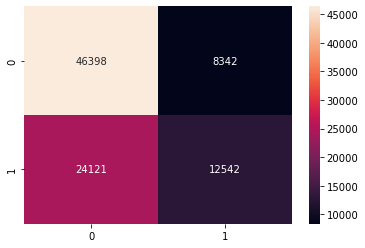

In [37]:
cat_cm=confusion_matrix(y_test, cat_results_optuna)
sns.heatmap(cat_cm, annot=True, fmt='d')
plt.show()

In [40]:
def objective_cat_roc(trial):
    """Define the objective function"""

    params = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'random_state': 1,
        'verbose':False
    }

    # Fit the model
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = roc_auc_score(y_test, y_pred)
    return accuracy

In [41]:
study = optuna.create_study(direction='maximize')

[I 2023-03-28 18:31:50,604] A new study created in memory with name: no-name-972cd6da-9eba-486c-bfcd-5f0a23f18f71


In [42]:
study.optimize(objective_cat_roc, n_trials=30)

[I 2023-03-28 18:34:38,346] Trial 0 finished with value: 0.5724729014569508 and parameters: {'iterations': 739, 'learning_rate': 0.021439307732022093, 'depth': 10, 'l2_leaf_reg': 9.275695860916549e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00027190425374694897, 'bagging_temperature': 9.691138552068683, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 0 with value: 0.5724729014569508.
[I 2023-03-28 18:35:23,635] Trial 1 finished with value: 0.5274419962838613 and parameters: {'iterations': 595, 'learning_rate': 0.004761731981156146, 'depth': 6, 'l2_leaf_reg': 0.03527500253396112, 'bootstrap_type': 'Bayesian', 'random_strength': 1.6629249238875786e-06, 'bagging_temperature': 3.446275305285683, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 0 with value: 0.5724729014569508.
[I 2023-03-28 18:36:54,800] Trial 2 finished with value: 0.5657878023328955 and parameters: {'iterations': 548, 'learning_rate': 0.021241535994923098, 'depth': 10, 'l2_leaf_reg': 0.06283017531337644, 'bo

[I 2023-03-28 18:55:40,249] Trial 20 finished with value: 0.5892079371354281 and parameters: {'iterations': 806, 'learning_rate': 0.06866584030930899, 'depth': 9, 'l2_leaf_reg': 0.0011707128267488352, 'bootstrap_type': 'Bayesian', 'random_strength': 8.571635341936245, 'bagging_temperature': 3.4225735430437876, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 16 with value: 0.5926429381072096.
[I 2023-03-28 18:56:55,039] Trial 21 finished with value: 0.5889476790207336 and parameters: {'iterations': 910, 'learning_rate': 0.08232473952520095, 'depth': 8, 'l2_leaf_reg': 1.4611994176867365e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.5607909215280422, 'bagging_temperature': 6.17041499463167, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 16 with value: 0.5926429381072096.
[I 2023-03-28 18:58:15,974] Trial 22 finished with value: 0.5935211439734335 and parameters: {'iterations': 983, 'learning_rate': 0.09930786671166644, 'depth': 8, 'l2_leaf_reg': 5.810885528521919e-06,

## Conclusions:
    # best ROC AUC score were for LGBMClassifier model with class_weight - 60,8 %
    # best accuracy score were for CatBoostClassifier model with class_weight - 64,7 % (the same result 
    # gives cross-validation)
    # hyperparameters tuning didn't improve the results